In [1]:
import mib as mb1
import mib_v2_3_3 as mb
import matplotlib.pyplot as plt
import time
import tracemalloc
import tpproc as tp
from collections import Counter  #regresa un diccionario con conteos
import glob
from collections import OrderedDict #diccionarios ordenados
import numpy as np
import pandas as pd
from itertools import product
import json
import math

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rober\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rober\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rober\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rober\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\rober\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


# Test 1

## Planteamiento

Comprobar del rendimiento del motor de inferencia con problema pequeño y con tres eventos con distribuciones uniformes, donde su cardinalidad de los tres va de uno a cien.

### Variables

- $A = \{0, 2, ..., n-1\}$

- $B = \{0, 2, ..., n-1\}$

- $C = \{0, 2, ..., n-1\}$

### Modelo de descomposición

$P(ABC) = P(A)P(B|A)P(C|AB)$.

$\;\;\;\;\;\;\;\;\;\;\;\;$<img src="./Imagenes/P(ABC).jpg" width=200/>

### Formas 

$P(A)$, $P(B|A)$ y $P(C|AB)$ serán distribuciones uniformes.

## Test

### MIB1.0

In [ ]:
n = 25
timesM1 = []
memoryM1 = []

timesC1 = []
memoryC1 = []

for i in range(21,22):
    Events = [x for x in range(i+1)]
    # Varaibles
    A = mb1.Var('A',Events)
    B = mb1.Var('B',Events)
    C = mb1.Var('C',Events)

    dA = {}
    dB_A = {}
    dC_AB = []
    value = 1 / (i+1)
    for e in Events:
        dA[e] = value
        dB_A[e] = {}
        for e1 in Events:
            dB_A[e][e1] = value
            tC_AB = []
            for e2 in Events:
                tC_AB.append(value)
            dC_AB.append(tuple(tC_AB))
    
    PA=mb1.Distrib(name='P(A)',variable=[A],tabla=dA)
    PB_A=mb1.DistribCond(name='P(B|A)',var=B,indep=[A],tabla=dB_A)
    PC_AB=mb1.DistribCond('P(C|AB)',C,[A,B],dC_AB)
    
    PABC=mb1.JointDistrib(name='P(ABC)',variables=[A,B,C],descomp=[PA,PB_A,PC_AB])
    Q_ABC=mb1.Question(joint=PABC)

    #Inferencia de P(B)
    tracemalloc.start()
    
    inicio = time.time()
    PB = Q_ABC.query(searched=[B])
    fin = time.time()
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesM1.append(tiempo_ejecucion)
    memoryM1.append(memoria_pico)
    
    #Inferencia de P(A|BC)
    tracemalloc.start()
    
    inicio = time.time()
    PA_BC = Q_ABC.query(searched=[A], known=[B,C])
    fin = time.time() 
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesC1.append(tiempo_ejecucion)
    memoryC1.append(memoria_pico)

### MIB2.0

Complejidad $O(3) = 25^3$

In [22]:
n = 25
timesM = []
memoryM = []

timesC = []
memoryC = []
test_n = 20
for i in range(n):
    Events = set([x for x in range(i+1)])
    
    # Generación de distribuciones de probabilidad (Distribuciones uniformes).
    dA = {}
    dB_A = {}
    dC_AB = {}
    value = 1 / (i+1)
    for x in range(i+1):
        dA[(x,)] = value
        dB_A[(x,)] = {}
        for y in range(i+1):
            dB_A[(x,)][(y,)] = value
            dC_AB[(x,y)] = {}
            for z in range(i+1):
                dC_AB[(x,y)][(z,)] = value
    
    # Variables para el motor de inferencia.
    A = mb.Var('A', Events)
    PA = mb.Distrib(dA, (A,))
    B = mb.Var('B', Events)
    PB_A = mb.Distrib(dB_A, (B,), (A,))
    C = mb.Var('C', Events)
    PC_AB = mb.Distrib(dC_AB, (C,), (A,B))
    
    # Probabilidad conjunta (Espesificación) -> descripción 
    
    dsPABC = mb.Specification(set([A,B,C]), (PA, PB_A, PC_AB))

    Q_ABC = mb.Question(dsPABC)
    
    timesM_i = 0
    memoryM_i = 0
    timesC_i = 0
    memoryC_i = 0
    for j in range(test_n):
        # Inferencia de una distibución marginal
        tracemalloc.start()
        
        inicio = time.time()
        PB = Q_ABC.DistributionQuery(set([B]))
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        tiempo_ejecucion = fin - inicio
        
        timesM_i += tiempo_ejecucion
        memoryM_i += memoria_actual
        
        # Inferencia de una distibución condicional 
        tracemalloc.start()
        
        inicio = time.time()
        PA_BC = Q_ABC.DistributionQuery(set([A]), set([B,C]))
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        tiempo_ejecucion = fin - inicio
        
        timesC_i += tiempo_ejecucion
        memoryC_i += memoria_actual
    
    timesM.append(timesM_i / test_n)
    memoryM.append(memoryM_i / test_n)
    timesC.append(timesC_i/ test_n)
    memoryC.append(memoryC_i / test_n)

## Datos obtenidos

In [21]:
with open("versiones//datosMIB1.json", "r") as archivo_json:
    datos = json.load(archivo_json)
timesM1 = datos["timesM1"]
timesC1 = datos["timesC1"]
memoryM1 = datos["memoryM1"]
memoryC1 = datos["memoryC1"]

In [4]:
len(timesM1)

25

### Tiempos

#### Tiempos de inferencia para $P(B)$

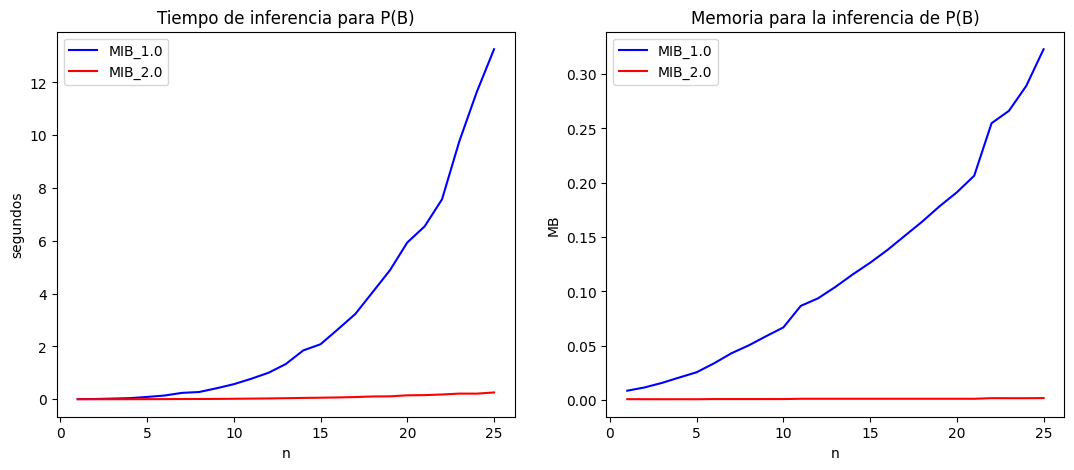

In [23]:
xn = [i+1 for i in range(n)]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(13,5)
# fig.set_size_inches(15,5)

ax[0].plot(xn, timesM1, color='b',label = 'MIB_1.0')
ax[0].plot(xn, timesM, color='r',label = 'MIB_2.0')
ax[0].set_title("Tiempo de inferencia para P(B)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("segundos")
ax[0].legend(loc = 'upper left')


ax[1].plot(xn, [m/1000000 for m in memoryM1], color='b',label = 'MIB_1.0')
ax[1].plot(xn, [m/1000000 for m in memoryM], color='r',label = 'MIB_2.0')
ax[1].set_title("Memoria para la inferencia de P(B)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("MB")
ax[1].legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

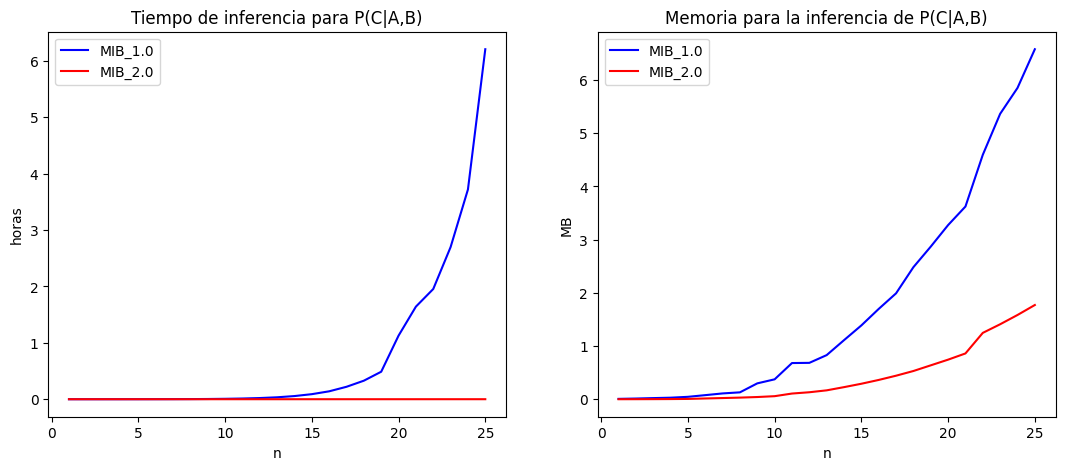

In [30]:
xn = [i+1 for i in range(n)]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(13,5)
# fig.set_size_inches(15,5)

ax[0].plot(xn, [t/3600 for t in timesC1], color='b',label = 'MIB_1.0')
ax[0].plot(xn, [t/3600 for t in timesC], color='r',label = 'MIB_2.0')
ax[0].set_title("Tiempo de inferencia para P(C|A,B)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("horas")
ax[0].legend(loc = 'upper left')


ax[1].plot(xn, [m/1000000 for m in memoryC1], color='b',label = 'MIB_1.0')
ax[1].plot(xn, [m/1000000 for m in memoryC], color='r',label = 'MIB_2.0')
ax[1].set_title("Memoria para la inferencia de P(C|A,B)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("MB")
ax[1].legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

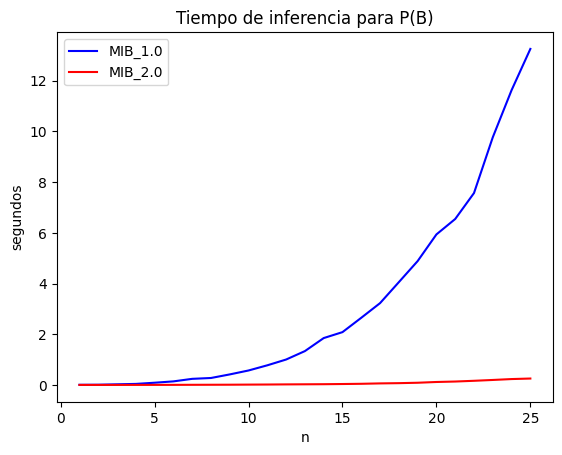

In [193]:
fig, ax = plt.subplots()
xn = [i+1 for i in range(n)]
# MIB_1.0
ax.plot(xn, timesM1, color='b', label = 'MIB_1.0')

# MIB_2.0
ax.plot(xn, timesM, color='r',label = 'MIB_2.0')
ax.set_title("Tiempo de inferencia para P(B)")

ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

In [ ]:
xn = [i+1 for i in range(n)]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10,4)
# fig.set_size_inches(15,5)
# MIB_1.0
ax[0].plot(xn, timesM1, color='b',label = 'MIB_1.0')
ax[0].plot(xn, timesM1, color='b',label = 'MIB_1.0')
ax[0].set_title("Tiempo de inferencia para P(B) (MIB_1.0)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("segundos")

# MIB_2.0
ax[1].plot(xn, timesM, color='r',label = 'MIB_2.0')
ax[1].set_title("Tiempo de inferencia para P(B) (MIB_2.0)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("segundos")

# Mostrar las gráficas
plt.show()

#### Tiempos de inferencia para $P(C|AB)$

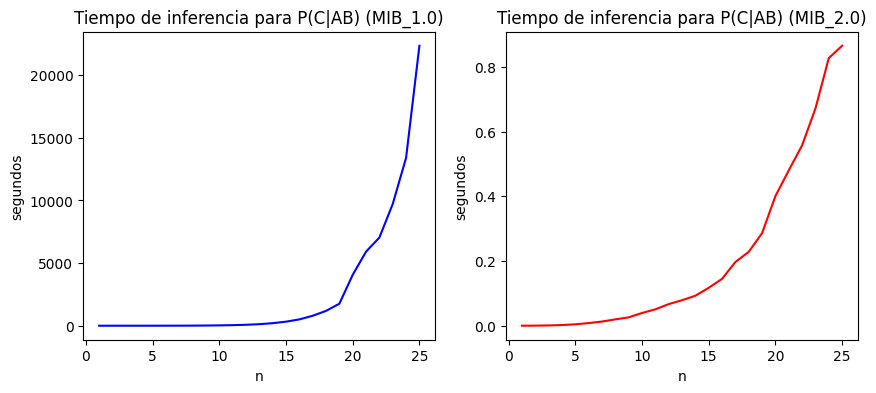

In [194]:
xn = [i+1 for i in range(n)]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10,4)
# MIB_1.0
ax[0].plot(xn, timesC1, color='b',label = 'MIB_1.0')
ax[0].set_title("Tiempo de inferencia para P(C|AB) (MIB_1.0)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("segundos")

# MIB_2.0
ax[1].plot(xn, timesC, color='r',label = 'MIB_2.0')
ax[1].set_title("Tiempo de inferencia para P(C|AB) (MIB_2.0)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("segundos")

# Mostrar las gráficas
plt.show()

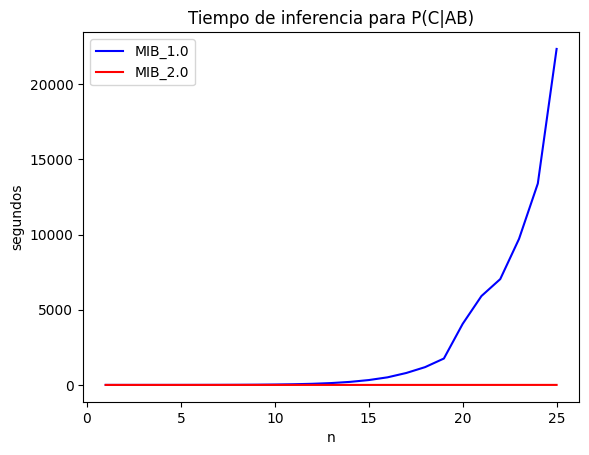

In [195]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, timesC1, color='b', label = 'MIB_1.0')

# MIB_2.0
ax.plot(xn, timesC, color='r',label = 'MIB_2.0')
ax.set_title("Tiempo de inferencia para P(C|AB)")

ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

### Memoria

#### Memoria para la inferencia de P(B)

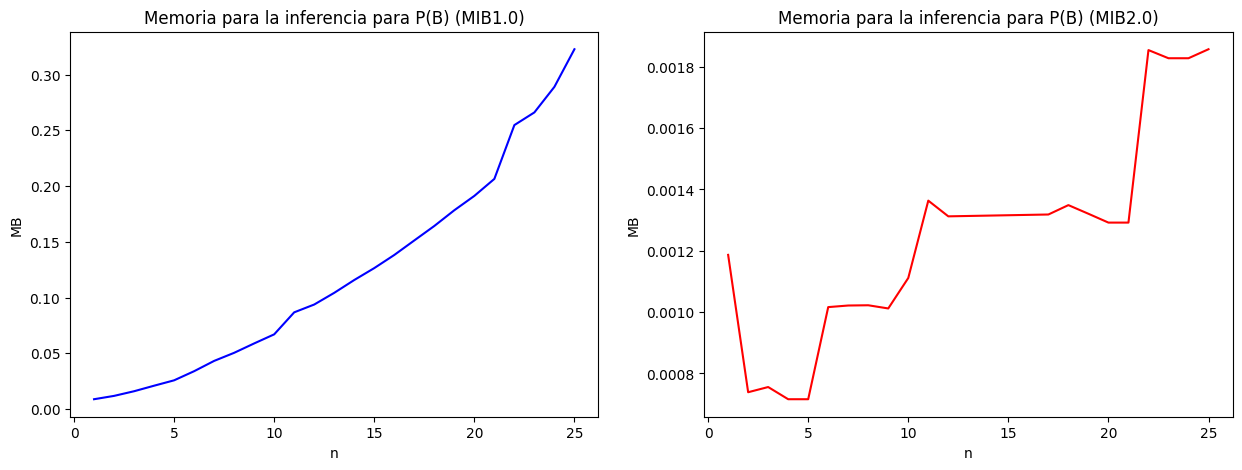

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15,5)
# MIB_1.0
ax[0].plot(xn, [m/1000000 for m in memoryM1], color='b',label = 'MIB_1.0')
ax[0].set_title("Memoria para la inferencia de P(B) (MIB1.0)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("MB")

# MIB_2.0
ax[1].plot(xn, [m/1000000 for m in memoryM], color='r',label = 'MIB_2.0')
ax[1].set_title("Memoria para la inferencia para P(B) (MIB2.0)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("MB")

# Mostrar las gráficas
plt.show()

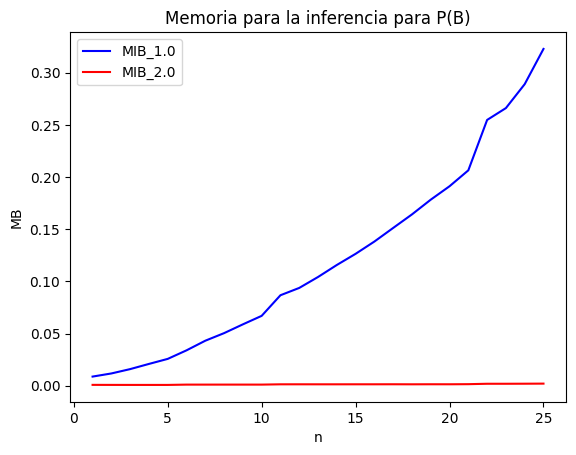

In [17]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, [m/1000000 for m in memoryM1], color='b',label = 'MIB_1.0')

# MIB_2.0
ax.plot(xn, [m/1000000 for m in memoryM], color='r',label = 'MIB_2.0')
ax.set_title("Memoria para la inferencia para P(B)")

ax.set_xlabel("n")
ax.set_ylabel("MB")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

#### Memoria para la inferencia de P(C|AB)

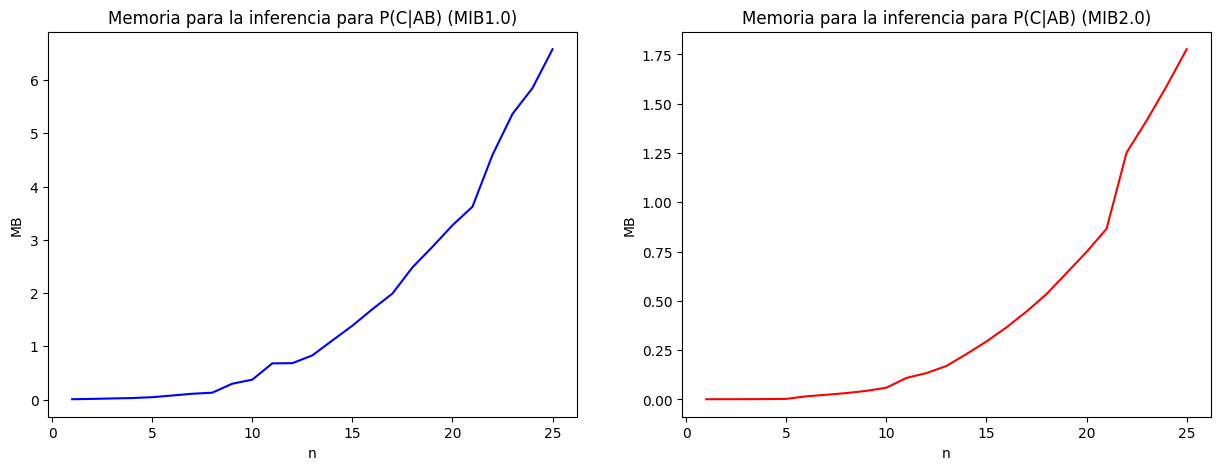

In [18]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15,5)
# MIB_1.0
ax[0].plot(xn, [m/1000000 for m in memoryC1], color='b',label = 'MIB_1.0')
ax[0].set_title("Memoria para la inferencia para P(C|AB) (MIB1.0)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("MB")

# MIB_2.0
ax[1].plot(xn, [m/1000000 for m in memoryC], color='r',label = 'MIB_2.0')
ax[1].set_title("Memoria para la inferencia para P(C|AB) (MIB2.0)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("MB")

# Mostrar las gráficas
plt.show()

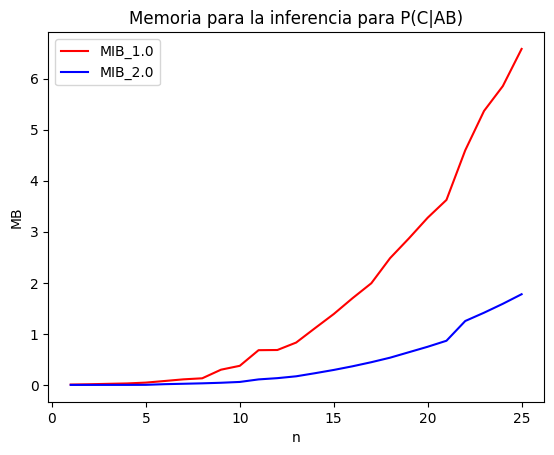

In [19]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, [m/1000000 for m in memoryC1], color='r',label = 'MIB_1.0')
# MIB_2.0
ax.plot(xn, [m/1000000 for m in memoryC], color='b',label = 'MIB_2.0')

ax.set_title("Memoria para la inferencia para P(C|AB)")

ax.set_xlabel("n")
ax.set_ylabel("MB")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

# Test 2

## Planteamiento

Comprobar del rendimiento del motor de inferencia n variables binarias.

### Variables

$X = \{X_1, X_2,\dots,X_n\}$, donde $\forall X_i \in X, X_i = \{0,1\}$.

### Modelo de descomposición

$P(X) = P(X_1)P(X_2|X_1)P(X_3|X_1,X_2) \cdots P(X_n|X_1,\dots,X_{n-1})$.

## Test

### MIB1.0

### MIB2.0

Complejidad: $O(n) = 2^n$

$t_m(n) = 2^n * n$

#### Conjunta

In [136]:
from itertools import product
n = 20
timesM = []
memoryM = []
timesM_A = []
memoryM_A = []
test_n = 5
for i in range(n):
    print(i+1)
    values = set([0,1])
    
    vars = tuple([mb.Var("X"+str(j+1), values) for j in range(i+3)])
    

    for j,var in enumerate(vars):
        if j == 0:
            tX1 = {(0,):0.5, (1,):0.5}
            descomp = [mb.Distrib(tX1, (var,))]
        else:
            for r in range(j):
                tXn = {}
                values_n = [list(xn.values) for xn in vars[:r+1]]
                for key in product(*values_n):
                    tXn[key] = {(0,):0.5, (1,):0.5}
            descomp.append(mb.Distrib(tXn, (var,), tuple(vars[:j]) ))
    
    QX1Xn = mb.Question(mb.Specification(set(vars), tuple(descomp)))
    
    timesM_i = 0
    memoryM_i = 0
    timesM_Ai = 0
    memoryM_Ai = 0
    
    for m in range(test_n):
        print(f"\t{m+1}")
        # Inferencia de una distibución marginal
        """ tracemalloc.start()
        
        inicio = time.time()
        PXn = QX1Xn.DistributionQuery(set([vars[-1]]))
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        tiempo_ejecucion = fin - inicio
        
        timesM_i += tiempo_ejecucion
        memoryM_i += memoria_actual """
        
        # Aproximación de una distibución marginal
        tracemalloc.start()
        
        inicio = time.time()
        PXn = QX1Xn.DistributionQuery(set([vars[-1]]), aproximation=True, process_n=16)
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        tiempo_ejecucion = fin - inicio
        
        timesM_Ai += tiempo_ejecucion
        memoryM_Ai += memoria_actual
    
    # timesM.append(timesM_i / test_n)
    # memoryM.append(memoryM_i / test_n)
    timesM_A.append(timesM_Ai / test_n)
    memoryM_A.append(memoryM_Ai / test_n)

1
	1
	2
	3
	4
	5
2
	1
	2
	3
	4
	5
3
	1
	2
	3
	4
	5
4
	1
	2
	3
	4
	5
5
	1
	2
	3
	4
	5
6
	1
	2
	3
	4
	5
7
	1
	2
	3
	4
	5
8
	1
	2
	3
	4
	5
9
	1
	2
	3
	4
	5
10
	1
	2
	3
	4
	5
11
	1
	2
	3
	4
	5
12
	1
	2
	3
	4
	5
13
	1
	2
	3
	4
	5


KeyboardInterrupt: 

#### Condicional

In [65]:
n = 5
timesC = []
memoryC = []
timesC_A = []
memoryC_A = []

test_n = 10
N = 40000
for i in range(n):
    print(i+1)
    values = set([0,1])
    
    vars = tuple([mb.Var("X"+str(j), values) for j in range(i+2)])

    for j,var in enumerate(vars):
        if j == 0:
            dX0 = {(0,):0.5, (1,):0.5}
            descomp = [mb.Distrib(dX0, (var,))]
        elif j == 1:
            dX1 = {
                (0,) : {(0,):0.5, (1,):0.5},
                (1,) : {(0,):0.5, (1,):0.5}
            }
            descomp.append(mb.Distrib(dX1, (var,), (vars[0],),))
        else:
            dXn = {}
            values_n = [list(xn.values) for xn in vars[:j-1]]
            for key in product(*values_n):
                dXn[key] = {(0,):0.5, (1,):0.5}
            descomp.append(mb.Distrib(dXn, (var,), tuple(vars[:j-1])))
    
    QX1Xn = mb.Question(mb.Specification(set(vars), tuple(descomp)))
    
    timesC_i = 0
    memoryC_i = 0
    timesC_Ai = 0
    memoryC_Ai = 0
    for m in range(test_n):
        print(f"\t{m+1}")
        # Inferencia de una distibución condicional 
        """ tracemalloc.start()
        
        inicio = time.time()
        PX1_X2Xn = QX1Xn.DistributionQuery(set([vars[0]]), set([vars[1],vars[-1]]))
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        tiempo_ejecucion = fin - inicio
        
        timesC_i += tiempo_ejecucion
        memoryC_i += memoria_actual """
        
        # Aproximación de una distibución condicional 
        tracemalloc.start()
        
        inicio = time.time()
        PX1_Xn = QX1Xn.DistributionQuery(set([vars[0]]), set([vars[-1]]), aproximation=True, N=N)
        # PX1_X2Xn = QX1Xn.DistributionQuery(set([vars[0]]), set([vars[1],vars[-1]]), aproximation=True)
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        tiempo_ejecucion = fin - inicio
        
        timesC_Ai += tiempo_ejecucion
        memoryC_Ai += memoria_actual
    
    # timesC.append(timesC_i/ test_n)
    # memoryC.append(memoryC_i / test_n)
    timesC_A.append(timesC_Ai / test_n)
    memoryC_A.append(memoryC_Ai / test_n)
    

1
	1


KeyboardInterrupt: 

In [140]:
mp = 0
for i in range(1,100):
    mp += (timesC_A[i] - timesC_A[i-1])
mp / (100 - 1)

2.0694586859809028

In [50]:
def t1000(x:int) -> float:
    return 0.11763986216651068 * x

In [51]:
def t10000(x:int) -> float:
    return (0.8919548723432753 * x)  + 0.3183024686721987

In [52]:
def t17500(x:int, b:float = 0.0005555581286976537) -> float:
    return (2.0694586859809028 * x) + b

In [53]:
def t25000(x:int, b:float = -0.041077795471430104):
    return (3.24696249961853 * x) + b

In [54]:
def t50000(x:int) -> float:
    return (6.563827234506607 * x) - 0.31809051576543457

In [139]:
timesC_A = []
for i in range(100):
    d = t25000(i+2) - t10000(i+2)
    t = t10000(i+2) + (d/2)
    timesC_A.append(t)

In [151]:
e = 0
for i in range(100):
    e += (timesC_A[i] - t17500(i+2)) / timesC_A[i]
e / (n-1)

0.0005555671618301966

In [147]:
e = 0
b = 0.0005555581286976537
for j in range(10000):
    for i in range(100):
        e += (timesC_A[i] - (t25000(i+2, b))) / timesC_A[i]
        # e += (timesC_A[i] - t10000(i+2)) / timesC_A[i]
    e = e / (n-1)
    b = (b+e) / 2
b

-0.11292298264205164

In [256]:
i = 8
timesC_A[i], t10000(i+2)

(9.285991668701172, 9.237851192104952)

In [165]:
t1000(500)

0.9803321847209223

In [265]:
(t10000(500) / 60) * 10

74.3826231067183

In [15]:
import json

""" # Diccionario que deseas guardar
mi_diccionario = {
    "timesM": timesM,
    "timesC": timesC,
    "memoryM": memoryM,
    "memoryC": memoryC
}

# Guardar el diccionario en un archivo JSON
with open("datos_MIB2.json", "w") as archivo_json:
    json.dump(mi_diccionario, archivo_json, indent=4) """
    
# mi_diccionario.clear()
mi_diccionario = {
    "timesM": timesM_A,
    "timesC": timesC_A,
    "memoryM": memoryM_A,
    "memoryC": memoryC_A
}

# Guardar el diccionario en un archivo JSON
with open("datosA_MIB2.json", "w") as archivo_json:
    json.dump(mi_diccionario, archivo_json, indent=4)

NameError: name 'timesM_A' is not defined

In [57]:
with open("datos_MIB2.json", "r") as archivo_json:
    datos = json.load(archivo_json)
timesM = datos["timesM"]
timesC = datos["timesC"]
memoryM = datos["memoryM"]
memoryC = datos["memoryC"]

In [58]:
with open("datosA_MIB2.json", "r") as archivo_json:
    datos = json.load(archivo_json)
timesMA = datos["timesM"]
timesCA = datos["timesC"]
memoryMA = datos["memoryM"]
memoryCA = datos["memoryC"]

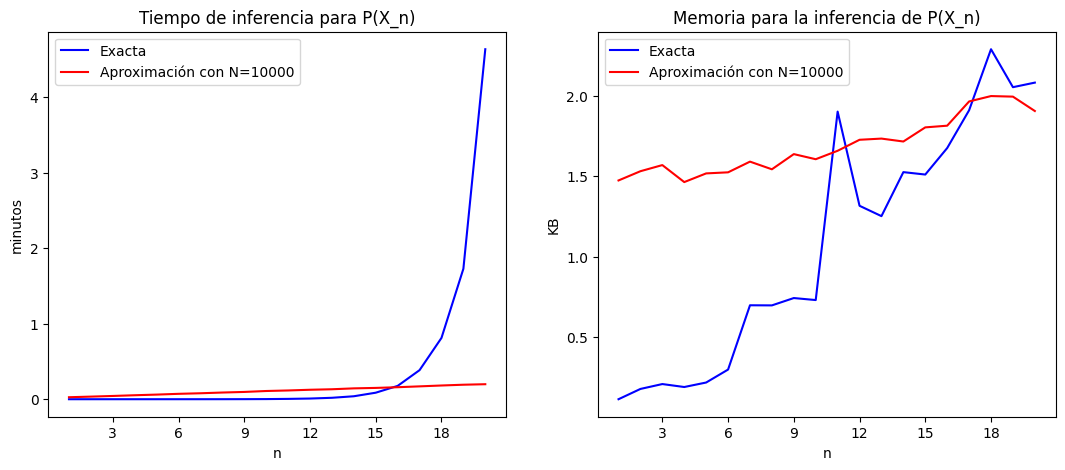

In [59]:
from matplotlib.ticker import MaxNLocator

xn = [i+1 for i in range(20)]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(13,5)
# fig.set_size_inches(15,5)

ax[0].plot(xn, [t/60 for t in timesM], color='b',label = 'Exacta')
ax[0].plot(xn, [t/60 for t in timesMA], color='r',label = 'Aproximación con N=10000')
ax[0].set_title("Tiempo de inferencia para P(X_n)")
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_xlabel("n")
ax[0].set_ylabel("minutos")
ax[0].legend(loc = 'upper left')


ax[1].plot(xn, [m/1000 for m in memoryM], color='b',label = 'Exacta')
ax[1].plot(xn, [m/1000 for m in memoryMA], color='r',label = 'Aproximación con N=10000')
ax[1].set_title("Memoria para la inferencia de P(X_n)")
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_xlabel("n")
ax[1].set_ylabel("KB")
ax[1].legend(loc = 'upper left')


# Mostrar las gráficas
plt.show()

## Datos

In [2]:
def grafica_(list1, list2, title1, title2, xn, x_label, y_label):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12,6)
    ax[0].plot(xn, list1, color='b',label = 'Exacta')
    ax[0].set_title(title1)
    ax[0].set_xlabel(x_label)
    ax[0].set_ylabel(y_label)


    ax[1].plot(xn, list2, color='r',label = 'Aproximación')
    ax[1].set_title(title2)
    ax[1].set_xlabel(x_label)
    ax[1].set_ylabel(y_label)
    
    plt.show()
    

In [3]:
def grafica_n(ys:list, x:list, labels:list,  title:str, x_label:str, y_label:str) -> None:
    fig, ax = plt.subplots()
    
    for i,y in enumerate(ys):
        ax.plot(x[i], y, label = labels[i])
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(loc = 'upper left')
    plt.grid()
    plt.show()

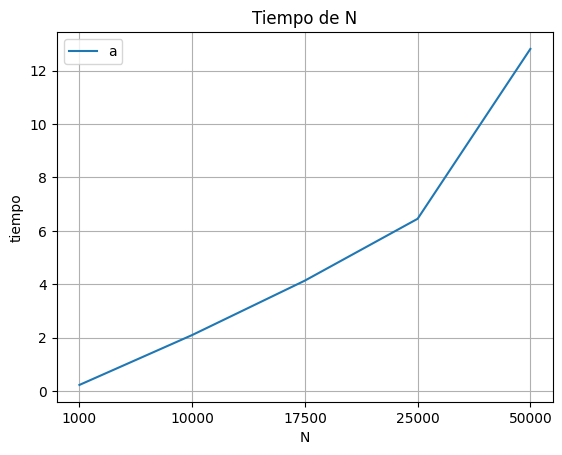

In [64]:
Ns = [t1000(2),t10000(2),t17500(2),t25000(2),t50000(2)]
xn = ['1000', '10000','17500','25000','50000']

grafica_n([Ns], [xn], ["a"], 'Tiempo de N', 'N', 'tiempo')


### Marginal

#### Tiempos

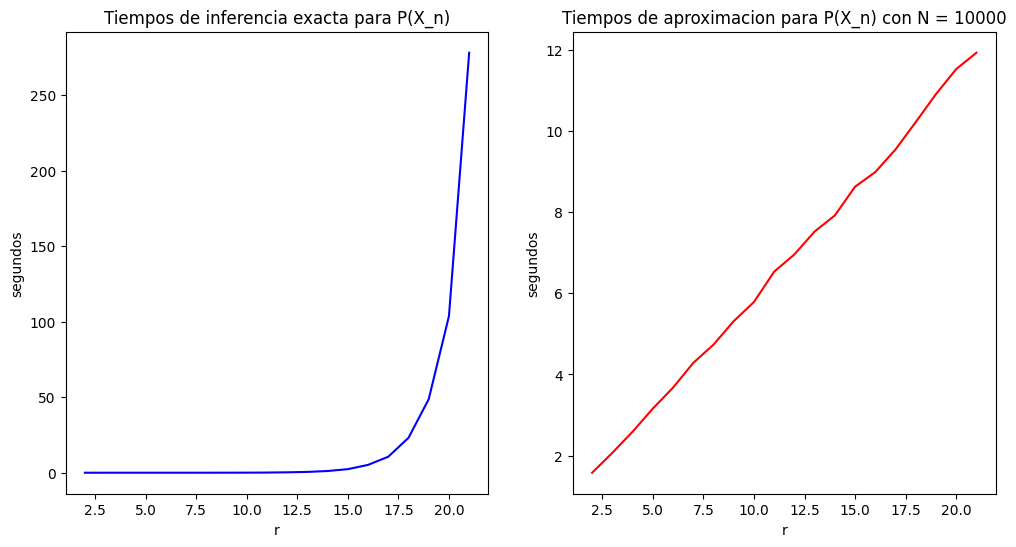

In [ ]:
xn = [i+2 for i in range(n)]
title1 = "Tiempos de inferencia exacta para P(X_n)"
title2 = "Tiempos de aproximacion para P(X_n) con N = 10000"
grafica_(timesM, timesM_A, title1, title2, xn, 'n', 'segundos')

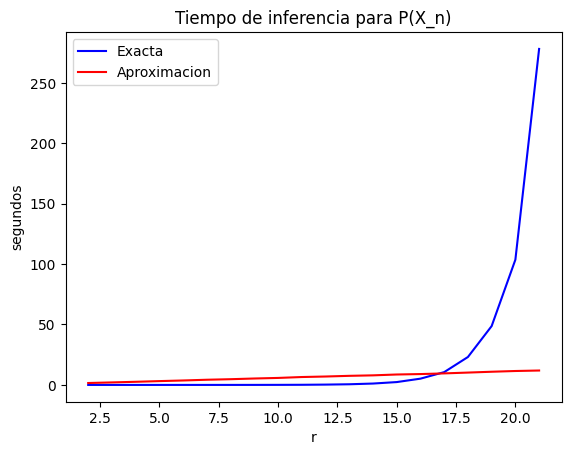

In [31]:
grafica_n([timesM, timesM_A], ['Exacta', 'Aproximacion'], "Tiempo de inferencia para P(X_n)", xn, 'n', 'segundos')

#### Memoria 

In [ ]:
xn = [i+2 for i in range(n)]
title1 = "Memoria para la inferencia exacta de P(X_n)"
title2 = "Memoria para la aproximacion de P(X_n) con N = 10000"
grafica_(memoryM, memoryM_A, title1, title2, xn, 'r', 'segundos')

In [ ]:
grafica_n([memoryM, memoryM_A], ['Exacta', 'Aproximacion'], "Memoria para la inferencia de P(X_n)", xn, 'n', 'segundos')

### Condicional 

#### Tiempos

In [ ]:
n = 500
t_mil = [t1000(i+2) / 60 for i in range(n)]
t_10mil = [t10000(i+2) / 60 for i in range(n)]
t_25mil = [t25000(i+2) / 60 for i in range(n)]
t_50mil = [t50000(i+2) / 60 for i in range(n)]
x = [i+2 for i in range(n)]

labels = ['N=1000','N=10000','N=25000','N=50000']
ys = [t_mil, t_10mil, t_25mil,t_50mil]

grafica_n(ys, x, labels,'Tiempo de Aproximación para P(X_1|X_2,X_n)','n', 'mins')

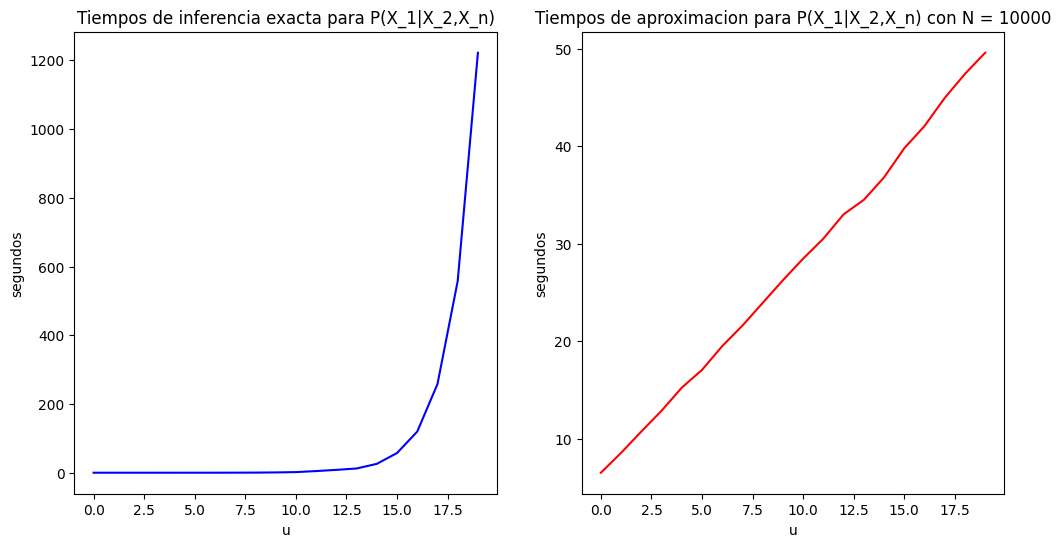

In [28]:
xn = [i for i in range(n)]
title1 = "Tiempos de inferencia exacta para P(X_1|X_2,X_n)"
title2 = "Tiempos de aproximacion para P(X_1|X_2,X_n) con N = 10000"
grafica_(timesC, timesC_A, title1, title2, xn, 'u', 'segundos')

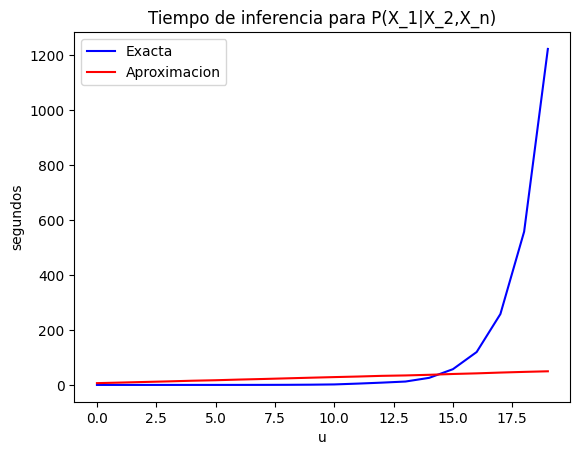

In [29]:
grafica(timesC, timesC_A, 'Exacta', 'Aproximacion', "Tiempo de inferencia para P(X_1|X_2,X_n)", xn, 'u', 'segundos')

#### Memoria

In [ ]:
xn = [i for i in range(n)]
title1 = "Memoria para la inferencia exacta de P(X_1|X_2,X_n)"
title2 = "Memoria para la aproximacion de P(X_1|X_2,X_n) con N = 10000"
grafica_(timesC, timesC_A, title1, title2, xn, 'u', 'segundos')

In [ ]:
grafica(timesC, timesC_A, 'Exacta', 'Aproximacion', "Memoria para la inferencia de P(X_1|X_2,X_n)", xn, 'u', 'segundos')

# Test 3

## Planteaminto 

### Especificación 

#### Variables

- $Spam$: Variable para el spam
- $W_i$: Varibale para las palabras.

##### $Spam$

$Spam = \{0,1\}$, donde si $Spam = 0$ el SMS no es spam, otro caso, es spam.

##### $W_i$

$W_i = \{0,1\}$, donde si $W_i = 0$ la palabra $i$ no esta presente en el SMS, caso contrario, si esta presente.

#### Descomposicón

Sea $W = \{W_1,W_2,\dots,W_n\} $

$P(Spam,W) = P(Spam)\prod_{i=0}^{n}P(W_i|Spam) $

#### Formas

##### $P(Sapm)$

$P(Spam) = \frac{n_{ham}}{n_{SMS}}$, donde $n_{ham}$ es el número de SMS que no son spam y $n_{SMS}$ es el número de SMS.

$P(\neg Spam) = 1 - P(Spam)$

##### $\forall W_i \in W, P(W_i|Spam)$

* $P(W_i = true | Spam = false) = \frac{1 + {n^i}_f}{|W_i| + n_f}$
* $P(W_i = true | Spam = true) = \frac{1 + {n^i}_v}{|W_i| + n_v}$

donde, ${n^i}_f$ es el número de apariciones de la i-ésima palabra en SMS que no son spam y $n_f$ es el número total de SMS que no son spam, ${n^i}_v$ es el número de apariciones de la i-ésima palabra en SMS que son spam y $n_v$ es el número total de SMS que son spam.

## Identificación e implementación

### Obtención de datos

In [2]:
df_train, df_test = tp.load_sms('Spam_SMS.csv')
print(len(df_train), len(df_test))

4459 1113


In [3]:
print(len(df_train[df_train['Class'] == 'spam']))

592


In [4]:
df_train, df_test = tp.dfpp(df_train, df_test)

In [5]:
df_train.head()

,Class,Message,Tokens,Bigrams
0,ham,You still coming tonight?,"[still, coming, tonight]","[(PRP, RB), (RB, VBG), (VBG, RB), (RB, .)]"
1,ham,"""HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DE...","[hey, babe, far, 2, spun-out, 2, spk, da, mo, ...","[(``, NNP), (NNP, NNP), (NNP, .), (., NNP), (N..."
2,ham,Ya even those cookies have jelly on them,"[ya, even, cooky, jelly]","[(NNP, RB), (RB, DT), (DT, NNS), (NNS, VBP), (..."
3,ham,Sorry i've not gone to that place. I.ll do so ...,"[sorry, 've, gone, place, i.ll, tomorrow, real...","[(NNP, VBP), (VBP, VBP), (VBP, RB), (RB, VBN),..."
4,ham,When are you going to ride your bike?,"[going, ride, bike]","[(WRB, VBP), (VBP, PRP), (PRP, VBG), (VBG, TO)..."


In [6]:
df_test.head()

,Class,Message,Tokens,Bigrams
4460,ham,Was playng 9 doors game and gt racing on phone...,"[playng, 9, door, game, gt, racing, phone, lol]","[(NNP, RB), (RB, CD), (CD, NNS), (NNS, NN), (N..."
4461,ham,I dont thnk its a wrong calling between us,"[dont, thnk, wrong, calling, u]","[(PRP, VBP), (VBP, VB), (VB, PRP$), (PRP$, DT)..."
4462,ham,All e best 4 ur exam later.,"[e, best, 4, ur, exam, later]","[(DT, VBP), (VBP, JJS), (JJS, CD), (CD, JJ), (..."
4463,ham,Hey what how about your project. Started aha da.,"[hey, project, started, aha, da]","[(NNP, WP), (WP, WRB), (WRB, RB), (RB, PRP$), ..."
4464,ham,Desires- u going to doctor 4 liver. And get a ...,"[desires-, u, going, doctor, 4, liver, get, bi...","[(NNP, NN), (NN, VBG), (VBG, TO), (TO, VB), (V..."


### Data frame de trabajo

### Reducción de vocabulario 

#### Función 

In [7]:
def redu_vocab_c(max:int, min:int = None) -> tuple:
    classes = set(df_train_T.Class)
    vocab_c = {}
    vocab = set()
    
    for c in classes:
        tks = df_train_T[df_train_T['Class'] == c].Tokens
        words = []
        
        for txt in tks:
            words = words + txt
        wsc = Counter(words)
        
        len_old_vocab = len(wsc)
        
        if min:
            vocab_c[c] = dict([(w, wsc[w]) for w in wsc if wsc[w] >= min and wsc[w] <= max])
        else:
            vocab_c[c] = dict([e for e in wsc.most_common(max)])
        new_vocab =  set([w for w in vocab_c[c].keys()])
        
        vocab = vocab.union(new_vocab)
        
        print(f"\n{c}:")
        print(f"Words: old: {len_old_vocab}, new:{len(new_vocab)}")
        
    return vocab, vocab_c

In [8]:
def redu_vocab(max_w:int, max_b:int, min_w:int = None, min_b:int = None) -> tuple:
    vocab_c = {}
    bigrams_c = {}
    vocab = set()
    bigrams = set()
    
    # Reducción del vocabulario
    
    # Obtención de tokens de ham
    tks_ham = df_train_T[df_train_T['Class'] == 'ham'].Tokens
    words = []
    for tk in tks_ham:
        words = words + tk
    ws_h = Counter(words)
    
    # Obtención de tokens de spam
    tks = df_train_T[df_train_T['Class'] == 'spam'].Tokens
    words = []
    for tk in tks:
        words = words + tk
    ws_c = Counter(words)
    
    # Vocabulario antiguo
    len_old_vocab = len(ws_c)

    # Reducción de vocabulario
    if min_w:
        vocab_c['spam'] = dict([(w, ws_c[w]) for w in ws_c if ws_c[w] >= min_w and ws_c[w] <= max_w])
    else:
        vocab_c['spam'] = dict([e for e in ws_c.most_common(max_w)])
    
    # Reducción de vacabulario de ham en base a spam
    t_vacab_h = []
    for w in ws_c.keys():
        if w in ws_h.keys():
            t_vacab_h.append((w, ws_h[w]))
        
    vocab_c['ham'] = dict(t_vacab_h)
    
    # Nuevo vocabulario
    new_vocab = set(vocab_c['spam'].keys())
        
    vocab = vocab.union(new_vocab)
    
    # Reducción de los bigramas
    
    # Obtención de bigramas de ham
    bg_ham = df_train_T[df_train_T['Class'] == 'ham'].Bigrams
    bgs = []
    for bg in bg_ham:
        bgs = bgs + bg
    bgs_ham = Counter(bgs)
    
    # Obtención de bigramas de spam 
    bg_spam = df_train_T[df_train_T['Class'] == 'spam'].Bigrams
    bgs = []
    for bg in bg_spam:
        bgs = bgs + bg
    bgs_spam = Counter(bgs)
    
    # Bigramas antiguo
    len_old_bgs = len(bgs_spam)
    
    # Reducción de bigramas
    if min_b:
        bigrams_c['spam'] = dict([(b, bgs_spam[b]) for b in bgs_spam if bgs_spam[b] >= min_b and bgs_spam[b] <= max_b])
    else:
        bigrams_c['spam'] = dict([b for b in bgs_spam.most_common(max_b)])
    
    # Reducción de bigramas de ham en base a spam
    t_bgs_h = []
    for b in bgs_spam.keys():
        if b in bgs_ham.keys():
            t_bgs_h.append((b, bgs_ham[b]))  
        
    bigrams_c['ham'] = dict(t_bgs_h)
    
    # Nuevos bigramas
    new_brigams = set(bigrams_c['spam'].keys())
        
    bigrams = bigrams.union(new_brigams) 
        
    print(f"\n{'spam'}:")
    print(f"Words: old: {len_old_vocab}, new:{len(new_vocab)}")
    print(f"Bigrams: old: {len_old_bgs}, new:{len(new_brigams)}")
    
    return vocab, vocab_c, bigrams, bigrams_c
        

#### Reducción

In [9]:
df_train_T = df_train.copy()
df_test_T = df_test.copy()

# df_train_T =  pd.concat([df_train_T[df_train_T['Class'] == 'spam'], df_train_T[df_train_T['Class'] == 'ham'][:int(0.2 * 592)]], ignore_index=True)

# vocab, vocab_c = redu_vocab_c(20)
vocab, vocab_c, bigrams, bigrams_c = redu_vocab(1000,1000,50,50)


spam:
Words: old: 2506, new:21
Bigrams: old: 613, new:76


In [10]:
df_train_T['Tokens'] = df_train_T.Tokens.\
    apply(lambda tokens: [w for w in tokens if w in vocab])
    
df_train_T['Bigrams'] = df_train_T.Bigrams.\
    apply(lambda big: [b for b in big if b in bigrams])

df_train_T[df_train_T['Class'] == 'ham'].head()

,Class,Message,Tokens,Bigrams
0,ham,You still coming tonight?,[],"[(RB, .)]"
1,ham,"""HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DE...","[2, 2, 2, 4, call]","[(NNP, .), (., NNP), (NNP, CD), (CD, JJ), (JJ,..."
2,ham,Ya even those cookies have jelly on them,[],"[(NNS, VBP), (IN, PRP)]"
3,ham,Sorry i've not gone to that place. I.ll do so ...,[],"[(DT, NN), (NN, .), (., NNP), (NN, .), (JJ, .)]"
4,ham,When are you going to ride your bike?,[],"[(TO, VB), (VB, PRP$), (PRP$, NN), (NN, .)]"


In [11]:
df_test_T['Tokens'] = df_test_T.Tokens.\
    apply(lambda tokens: [w for w in tokens if w in vocab])

df_test_T['Bigrams'] = df_test_T.Bigrams.\
    apply(lambda big: [b for b in big if b in bigrams])


df_test_T[df_test_T['Class'] == 'spam'].head()

,Class,Message,Tokens,Bigrams
4469,spam,PRIVATE! Your 2003 Account Statement for <fone...,[call],"[(JJ, .), (., PRP$), (CD, NNP), (NNP, IN), (IN..."
4474,spam,"Get 3 Lions England tone, reply lionm 4 mono o...","[get, reply, 4, 4, 4, 2]","[(VB, CD), (CD, NNP), (NNP, NN), (NN, ,), (VB,..."
4483,spam,How about getting in touch with folks waiting ...,[txt],"[(IN, NN), (NN, IN), (IN, NN), (NN, .), (., NN..."
4486,spam,-PLS STOP bootydelious (32/F) is inviting you ...,"[stop, reply, stop, send, stop]","[(JJ, NNP), (NNP, NN), (TO, VB), (VB, PRP$), (..."
4492,spam,A £400 XMAS REWARD IS WAITING FOR YOU! Our com...,"[mobile, call]","[(DT, NN), (NN, NNP), (NNP, NN), (NN, .), (., ..."


In [12]:
bigrams

{(',', 'NNP'),
 ('.', 'CD'),
 ('.', 'IN'),
 ('.', 'NN'),
 ('.', 'NNP'),
 ('.', 'PRP'),
 ('.', 'PRP$'),
 ('.', 'TO'),
 ('.', 'VB'),
 ('CC', 'NNP'),
 ('CC', 'VB'),
 ('CD', '.'),
 ('CD', 'CD'),
 ('CD', 'IN'),
 ('CD', 'JJ'),
 ('CD', 'NN'),
 ('CD', 'NNP'),
 ('CD', 'NNS'),
 ('CD', 'RB'),
 ('DT', 'JJ'),
 ('DT', 'NN'),
 ('DT', 'NNP'),
 ('IN', 'CD'),
 ('IN', 'DT'),
 ('IN', 'JJ'),
 ('IN', 'NN'),
 ('IN', 'NNP'),
 ('IN', 'PRP'),
 ('IN', 'PRP$'),
 ('JJ', '.'),
 ('JJ', 'CD'),
 ('JJ', 'JJ'),
 ('JJ', 'NN'),
 ('JJ', 'NNP'),
 ('JJ', 'NNS'),
 ('MD', 'VB'),
 ('NN', ','),
 ('NN', '.'),
 ('NN', ':'),
 ('NN', 'CC'),
 ('NN', 'CD'),
 ('NN', 'IN'),
 ('NN', 'NN'),
 ('NN', 'NNP'),
 ('NN', 'NNS'),
 ('NN', 'RB'),
 ('NN', 'TO'),
 ('NN', 'VBZ'),
 ('NNP', ','),
 ('NNP', '.'),
 ('NNP', 'CC'),
 ('NNP', 'CD'),
 ('NNP', 'IN'),
 ('NNP', 'JJ'),
 ('NNP', 'NN'),
 ('NNP', 'NNS'),
 ('NNP', 'TO'),
 ('NNS', '.'),
 ('NNS', 'IN'),
 ('NNS', 'VBP'),
 ('PRP', 'VBP'),
 ('PRP$', 'JJ'),
 ('PRP$', 'NN'),
 ('RB', '.'),
 ('RB', 'CD'),
 ('RB

In [13]:
vocab

{"'s",
 '2',
 '4',
 'c',
 'call',
 'cash',
 'claim',
 'free',
 'get',
 'mobile',
 'new',
 'prize',
 'reply',
 'send',
 'service',
 'stop',
 'text',
 'txt',
 'u',
 'ur',
 'urgent'}

### Variables

In [14]:
Spam = mb.Var('Spam', set(['spam','ham']))
W = {}
for w in vocab:
    W[w] = mb.Var(w, set([0,1]))
B = {}
for b in bigrams:
    B[b] = mb.Var(b, set([0,1]))

### Distribuciones

#### $P(Spam)$

In [15]:
cSpam = Counter(df_train_T.Class)
ttw = np.sum(list(cSpam.values()))
tSpam = {}
for c in cSpam.keys():
    tSpam[(c,)] = cSpam[c] / ttw

PSpam = mb.Distrib(tSpam, (Spam,))

In [16]:
PSpam.table

{('ham',): np.float64(0.8672348060103162),
 ('spam',): np.float64(0.13276519398968378)}

#### $\forall W_i \in W, P(W_i|Spam)$

In [17]:
PW_Spam = {}
nv_spam = np.sum(list(vocab_c['spam'].values()))
nv_ham = np.sum(list(vocab_c['ham'].values()))

for w in W.keys():
    tPW_Spam = {}
    tPW_Spam[('ham',)] = {}
    tPW_Spam[('spam',)] = {}
    
    if w in vocab_c['ham'].keys():
        pw_ns = (1 + vocab_c['ham'][w]) / (2 + nv_ham)
    else:
        pw_ns = 1 / (2 + nv_ham)
        
    tPW_Spam[('ham',)] = {(0,):1-pw_ns, (1,):pw_ns}
        
    if w in vocab_c['spam'].keys():
        pw_s = (1 + vocab_c['spam'][w]) / (2 + nv_spam)
    else:
        pw_s = 1 / (2 + nv_spam)
    
    tPW_Spam[('spam',)] = {(0,):1-pw_s, (1,):pw_s}
    
    PW_Spam[w] = mb.Distrib(tPW_Spam, (W[w],), (Spam,))

In [18]:
PW_Spam['call'].table

{('ham',): {(0,): np.float64(0.988366124893071),
  (1,): np.float64(0.011633875106928999)},
 ('spam',): {(0,): np.float64(0.8615604186489059),
  (1,): np.float64(0.1384395813510942)}}

#### $\forall B_i \in B, P(B_i|Spam)$

In [19]:
PB_Spam = {}
nb_spam = np.sum(list(bigrams_c['spam'].values()))
nb_ham = np.sum(list(bigrams_c['ham'].values()))

for b in B.keys():
    tPB_Spam = {}
    tPB_Spam[('ham',)] = {}
    tPB_Spam[('spam',)] = {}
    
    if b in bigrams_c['ham'].keys():
        pw_ns = (1 + bigrams_c['ham'][b]) / (2 + nb_ham)
    else:
        pw_ns = 1 / (2 + nb_ham)
        
    tPB_Spam[('ham',)] = {(0,):1-pw_ns, (1,):pw_ns}
        
    if b in bigrams_c['spam'].keys():
        pw_s = (1 + bigrams_c['spam'][b]) / (2 + nb_spam)
    else:
        pw_s = 1 / (2 + nb_spam)
    
    tPB_Spam[('spam',)] = {(0,):1-pw_s, (1,):pw_s}
    
    PB_Spam[b] = mb.Distrib(tPB_Spam, (B[b],), (Spam,))

### Especificación 

In [20]:
vars = set([Spam] + list(W.values()) + list(B.values()))
descomp = tuple([PSpam] + list(PW_Spam.values()) + list(PB_Spam.values()))
PSpamW = mb.Specification(vars,descomp)

In [21]:
# vars = set([Spam] + list(W.values()))
# descomp = tuple([PSpam] + list(PW_Spam.values()))
# PSpamW = mb.Specification(vars,descomp)

In [22]:
PSpamW.H()

np.float64(18.460980447876768)

## Pregunta

In [24]:
Q_SpamW = mb.Question(PSpamW)

In [62]:
# rango = 10
# incio = 8
# tests = df_test_T[incio-1:incio-1+rango]
tests = df_test_T[:10]

In [57]:
tests = df_test_T.sample(n=10, random_state=42)

In [65]:
p_test = []
aciertos = 0
i = 1
for index, test in tests.iterrows():
    print(f"Test: {i}")
    tokens = test['Tokens']
    # bigrams = test['Bigrams']
    
    # Wo = tuple([W[w] for w in tokens] + [B[b] for b in bigrams])
    Wo = tuple([W[w] for w in tokens])
    vWo = tuple(1 for i in range(len(Wo)))
    
    inicio = time.time()
    var, value, p = Q_SpamW.Query((Spam,), indep=Wo, indep_values=vWo, aproximation=True, N=20000)
    fin = time.time()
    
    print(f"\tP({value[0]}) = {p}, Class:{test['Class']}\n")
    
    if value[0] == test['Class']:
        aciertos += 1
    i+=1
    

Test: 1
	P(ham) = 0.87, Class:ham

Test: 2
	P(ham) = 0.5042, Class:ham

Test: 3
	P(ham) = 0.50465, Class:ham

Test: 4
	P(ham) = 0.8655, Class:ham

Test: 5
	P(ham) = 0.50475, Class:ham

Test: 6
	P(ham) = 0.4991, Class:ham

Test: 7
	P(ham) = 0.5034, Class:ham

Test: 8
	P(spam) = 0.50375, Class:ham

Test: 9
	P(ham) = 0.5007, Class:ham

Test: 10
	P(ham) = 0.5054, Class:spam



In [67]:
print(aciertos/len(tests))

0.8


In [65]:
[1000 * (i+1) for i in range(9,20)]

[10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000]

In [33]:
n = 10

# N_l = [10000 * (i+1) for i in range(10)]
N_l = [10000,25000,50000,75000,100000]
tiempoN = []
tiempoN4 = []
tiempoN8 = []
accuaracyN = []
test_i = 10
# tests = [df_test_T[i*test_i:test_i*(i+1)] for i in range(test_i * len(N_l))]
tests = df_test_T[4:14]
for N_i in N_l:
    aciertos = 0
    c = 0
    print(f"N = {N_i}")
    tiempo = 0
    tiempo4 = 0
    tiempo8 = 0
    
    i=0
    
    for index, test in tests.iterrows():
            print(f"test {i}")
            tokens = test['Tokens']
            bigrams = test['Bigrams']
            
            Wo = tuple([W[w] for w in tokens] + [B[b] for b in bigrams])
            #Wo = tuple([W[w] for w in tokens])
            vWo = tuple(1 for i in range(len(Wo)))
            
            inicio = time.time()
            var, value, p = Q_SpamW.Query((Spam,), indep=Wo, indep_values=vWo, aproximation=True, N=N_i)
            fin = time.time()
        
            tiempo += (fin - inicio)
            
            if value[0] == test['Class']:
                aciertos += 1
            c += 1
            
            # 4 precesos
            
            inicio = time.time()
            var, value, p = Q_SpamW.Query((Spam,), indep=Wo, indep_values=vWo, aproximation=True, N=int(N_i/4), process_n=4)
            fin = time.time()
        
            tiempo4 += (fin - inicio)
            
            if value[0] == test['Class']:
                aciertos += 1
            c += 1
            
            # 8 precesos
            
            inicio = time.time()
            var, value, p = Q_SpamW.Query((Spam,), indep=Wo, indep_values=vWo, aproximation=True, N=int(N_i/8), process_n=8)
            fin = time.time()
        
            tiempo8 += (fin - inicio)
            
            if value[0] == test['Class']:
                aciertos += 1
            c += 1
            
            
            i+=1 
        
    tiempoN.append(tiempo/test_i)
    tiempoN4.append(tiempo4/test_i)
    tiempoN8.append(tiempo8/test_i)
    accuaracyN.append(aciertos/c)

N = 10000
test 0
test 1
test 2
test 3
test 4
test 5
test 6
test 7
test 8
test 9
N = 25000
test 0
test 1
test 2
test 3
test 4
test 5
test 6
test 7
test 8
test 9
N = 50000
test 0
test 1
test 2
test 3
test 4
test 5
test 6
test 7
test 8
test 9
N = 75000
test 0
test 1
test 2
test 3
test 4
test 5
test 6
test 7
test 8
test 9
N = 100000
test 0
test 1
test 2
test 3
test 4
test 5
test 6
test 7
test 8
test 9


In [ ]:
len(tests)

50

In [31]:
tiempoN4 = [tiempoN4[i] for i in range(len(tiempoN4)) if i%2 == 0]

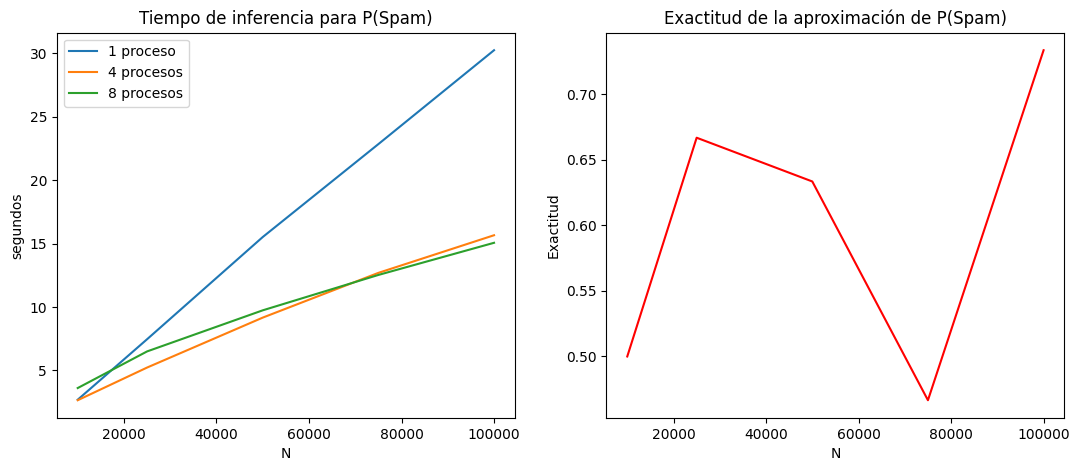

In [37]:


fig, ax = plt.subplots(1, 2)
fig.set_size_inches(13,5)
# fig.set_size_inches(15,5)


ax[0].plot(N_l, tiempoN, label = '1 proceso')
ax[0].plot(N_l, tiempoN4, label = '4 procesos')
ax[0].plot(N_l, tiempoN8, label = '8 procesos')
ax[0].set_title("Tiempo de inferencia para P(Spam)")
ax[0].set_xlabel("N")
ax[0].set_ylabel("segundos")
ax[0].legend(loc = 'upper left')


ax[1].plot(N_l, accuaracyN, color='r')
ax[1].set_title("Exactitud de la aproximación de P(Spam)")
ax[1].set_xlabel("N")
ax[1].set_ylabel("Exactitud")

# Mostrar las gráficas
plt.show()

In [ ]:
n = 10
tests = df_test_T[:n]
N_l = [1000 * (i+1) for i in range(10)]
tiempoN = []
tiempoN4 = []
tiempoN8 = []
exactitud = []
test_i = 5

for N_i in N_l:
    aciertos = 0
    for i in range(test_i):
        tiempo = 0
        tiempo4 = 0
        tiempo8 = 0
        
        print(f"Test: {i}")
        for index, test in tests.iterrows():
            
            tokens = test['Tokens']
            bigrams = test['Bigrams']
            
            Wo = tuple([W[w] for w in tokens] + [B[b] for b in bigrams])
            vWo = tuple(1 for i in range(len(Wo)))
            
            inicio = time.time()
            var, value, p = Q_SpamW.Query((Spam,), indep=Wo, indep_values=vWo, aproximation=True, N=N_i)
            fin = time.time()
            tiempo += (fin - inicio)
            
            if value[0] == test['Class']:
                aciertos += 1
            
            # 4 procesos
            
            inicio = time.time()
            var, value, p = Q_SpamW.Query((Spam,), indep=Wo, indep_values=vWo, aproximation=True, N=int(N_i/4), process_n = 4)
            fin = time.time()
            tiempo4 += (fin - inicio)
            
            if value[0] == test['Class']:
                aciertos += 1
            
            # 8 procesos
            
            inicio = time.time()
            var, value, p = Q_SpamW.Query((Spam,), indep=Wo, indep_values=vWo, aproximation=True, N=int(N_i/8), process_n = 8)
            fin = time.time()
            tiempo += (fin - inicio)
            
            if value[0] == test['Class']:
                aciertos += 1
            
    tiempoN.append(tiempo/test_i)
    accuaracyN.append(aciertos/(n*test_i))

In [ ]:

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(13,5)
# fig.set_size_inches(15,5)


ax[0].plot(N_l, tiempoN4, color='b')
ax[0].set_title("Tiempo de inferencia para P(Spam)")
ax[0].set_xlabel("N")
ax[0].set_ylabel("segundos")


ax[1].plot(N_l, accuaracyN4, color='r')
ax[1].set_title("Precisión de la aproximación de P(Spam)")
ax[1].set_xlabel("N")
ax[1].set_ylabel("Precisión")

# Mostrar las gráficas
plt.show()

# Test 3.1

Problema de autoria de textos 

## Plantemiento

### Especificaión 

#### Variables

- $A$ : Variable para los autores
- $T$ : Variable para los tipos de textos
- $W_I$ : Variable para las palabras

##### Variable $A$

$|A| = 10 $

##### Variable $T$

$ T = \{'minicuento', 'fábula', 'cuento'\} $

##### Variable $W_i$

$ W_i = \{0,1\}$, donde cada $W_i$ representa una variable para cada palabra.

Si $W_i$ es 0, entonces la palabra no esta. Si $W_i$ es 1 entonces la palabra esta.

$W = \{W_1,W_2,\dots,W_n\}$

#### Modelo de descomposición

$P(A)P(T|A)\displaystyle \prod_{i=0}^{n} P(W_i|AT)$

## Metodología

### Obtención de datos

#### Obtención de datos para el entrenamiento

In [2]:
archivos = glob.glob('./Train/*/*')
archivos = tp.carga_cuentos_(archivos)
df_train = tp.lee_cuentos_(archivos)
df_train.head()

,titulo,tipo,autor,tokens,bigramas
0,catástrofes,minicuento,alfonso reyes,"[¿qué, pasa, hablado, cierta, catástrofe, cósm...","[(VB, PRP), (PRP, VB), (VB, .), (., CC), (CC, ..."
1,del perfecto gobernante,minicuento,alfonso reyes,"[entiende, perfecto, gobernante, perfecto, lle...","[(NNP, VBD), (VBD, JJ), (JJ, NN), (NN, NN), (N..."
2,ley profunda,minicuento,alfonso reyes,"[trata, libertarnos, simplemente, enseñarnos, ...","[(NNP, NN), (NN, FW), (FW, FW), (FW, ,), (,, F..."
3,los alivios,minicuento,alfonso reyes,"[nombres, usan, castellano, w., c., restroom, ...","[(NNP, VBZ), (VBZ, JJ), (JJ, JJ), (JJ, JJ), (J..."
4,el buen rey león,fábula,esopo,"[león, enojoso, cruel, violento, sino, tratabl...","[(NNP, JJ), (JJ, NN), (NN, NN), (NN, DT), (DT,..."


#### Obtención de datos para el test

In [3]:
archivos = glob.glob('./Test/*')
archivos = tp.carga_cuentos_(archivos)
df_test = tp.lee_cuentos_(archivos,test=True)
df_test.head()

,titulo,tokens,bigramas
0,divina fragilidad,"[dios, creó, universo, sentía, solo, eternidad...","[(NNP, NN), (NN, NN), (NN, JJ), (JJ, NN), (NN,..."
1,dos seres iguales,"[cierto, día, profeta, sharía, encontró, niña,...","[(NNP, NN), (NN, ,), (,, FW), (FW, NN), (NN, N..."
2,el caballo y el lobo,"[estación, blandos, céfiros, hacen, verdear, c...","[(NNP, NN), (NN, NN), (NN, IN), (IN, JJ), (JJ,..."
3,el cetro,"[dijo, rey, esposa, -señora, verdaderamente, r...","[(NNP, JJ), (JJ, VBD), (VBD, DT), (DT, JJ), (J..."
4,el impostor,"[cansada, esperar, hombre, llegó, puntual, vi,...","[(NNP, NN), (NN, FW), (FW, FW), (FW, NN), (NN,..."


#### Función

In [4]:
def vocab_aut(max_w:int=5, max_b:int=20, min_b:int = None, min_w:int = None) -> set:
    autores = set(df_train.autor)
    bigram_a = {}
    vocab_a = {}
    new_vocab = set()
    new_bigrams = set()
    
    for a in autores:
        txts = df_train[df_train['autor'] == a].tokens
        all_bigrams = df_train[df_train['autor'] == a].bigramas
        
        bigrams = []
        for bigram in all_bigrams:
            bigrams = bigrams + bigram
        bs = Counter(bigrams)
        new_bigrams_a = set(bs)
        len_old_bigrams = len(new_bigrams_a)
        
        words = []
        for txt in txts:
            words = words + txt
        ws = Counter(words)
        
        new_vocab_a = set(ws)
        len_old_vocab = len(new_vocab_a)
        
        if min_b:
            vocab_a[a] = [(w, ws[w]) for w in ws if ws[w] >= min_w and ws[w] <= max_w]
        else:
            vocab_a[a] = [e for e in ws.most_common(max_w)]
        
        if min_b:
            bigram_a[a] = [(b, bs[b]) for b in bs if bs[b] >= min_b and bs[b] <= max_b]
        else:
            bigram_a[a] = [e for e in bs.most_common(max_b)]
            
        
        new_vocab_a =  set([w for w,_ in vocab_a[a]])
        new_bigrams_a = set([b for b,_ in bigram_a[a]])
        
        print(f"\n{a}:")
        print(f"Words: old: {len_old_vocab}, new:{len(new_vocab_a)}")
        print(f"Bigrams: old: {len_old_bigrams}, new:{len(new_bigrams_a)}")
        
        new_vocab = new_vocab.union(new_vocab_a)
        new_bigrams = new_bigrams.union(new_bigrams_a)
        
    print(len(new_vocab), len(new_bigrams))
    return new_vocab, new_bigrams, vocab_a, bigram_a

#### Reducción de vocabulario

In [50]:
# nuevo_vocabulario, nuevos_bigramas, nvocab_a, nbigram_a  = vocab_aut(5,50)
nuevo_vocabulario, nuevos_bigramas, nvocab_a, nbigram_a = vocab_aut(50, 500, min_b=10, min_w=10)


juan rulfo:
Words: old: 853, new:5
Bigrams: old: 160, new:48

horacio quiroga:
Words: old: 797, new:2
Bigrams: old: 153, new:41

carlos fuentes:
Words: old: 1373, new:6
Bigrams: old: 199, new:65

esopo:
Words: old: 166, new:0
Bigrams: old: 66, new:9

gabriel garcía márquez:
Words: old: 544, new:0
Bigrams: old: 121, new:35

jean de la fontaine:
Words: old: 390, new:0
Bigrams: old: 118, new:21

josé saramago:
Words: old: 420, new:1
Bigrams: old: 89, new:20

alfonso reyes:
Words: old: 219, new:0
Bigrams: old: 96, new:15

juan carlos onetti:
Words: old: 400, new:0
Bigrams: old: 97, new:17

gibrán jalil gibrán:
Words: old: 358, new:1
Bigrams: old: 112, new:21
14 70


#### Data Frames de trabajo

In [51]:
df_train_T = df_train.copy()
df_train_T['tokens'] = df_train_T.tokens.\
    apply(lambda tokens: [w for w in tokens if w in nuevo_vocabulario])
    
df_train_T['tokens_c'] = df_train_T.tokens.apply(Counter)

df_train_T['bigramas'] = df_train_T.bigramas.\
    apply(lambda bigramas: [b for b in bigramas if b in nuevos_bigramas])
    
df_train_T['bigramas_c'] = df_train_T.bigramas.apply(Counter)

df_train_T.head()

,titulo,tipo,autor,tokens,bigramas,tokens_c,bigramas_c
0,catástrofes,minicuento,alfonso reyes,[],"[(FW, FW), (FW, NN), (NN, NN), (NN, NN), (NN, ...",{},"{('FW', 'FW'): 6, ('FW', 'NN'): 6, ('NN', 'NN'..."
1,del perfecto gobernante,minicuento,alfonso reyes,[entonces],"[(NNP, VBD), (VBD, JJ), (JJ, NN), (NN, NN), (N...",{'entonces': 1},"{('NNP', 'VBD'): 1, ('VBD', 'JJ'): 1, ('JJ', '..."
2,ley profunda,minicuento,alfonso reyes,[],"[(NNP, NN), (NN, FW), (FW, FW), (FW, ,), (,, F...",{},"{('NNP', 'NN'): 2, ('NN', 'FW'): 2, ('FW', 'FW..."
3,los alivios,minicuento,alfonso reyes,[],"[(NNP, VBZ), (VBZ, JJ), (JJ, JJ), (JJ, JJ), (J...",{},"{('NNP', 'VBZ'): 1, ('VBZ', 'JJ'): 2, ('JJ', '..."
4,el buen rey león,fábula,esopo,[entonces],"[(NNP, JJ), (JJ, NN), (NN, NN), (NN, DT), (DT,...",{'entonces': 1},"{('NNP', 'JJ'): 1, ('JJ', 'NN'): 6, ('NN', 'NN..."


In [52]:
df_test_T = df_test.copy()
df_test_T['tokens'] = df_test_T.tokens.\
    apply(lambda tokens: [w for w in tokens if w in nuevo_vocabulario])
    
df_test_T['tokens_c'] = df_test_T.tokens.apply(Counter)

df_test_T['bigramas'] = df_test_T.bigramas.\
    apply(lambda bigramas: [b for b in bigramas if b in nuevos_bigramas])
    
df_test_T['bigramas_c'] = df_test_T.bigramas.apply(Counter)

df_test_T.head()

,titulo,tokens,bigramas,tokens_c,bigramas_c
0,divina fragilidad,[si],"[(NNP, NN), (NN, NN), (NN, JJ), (JJ, NN), (NN,...",{'si': 1},"{('NNP', 'NN'): 8, ('NN', 'NN'): 111, ('NN', '..."
1,dos seres iguales,"[aquí, hoy, aquí, entonces, aquí]","[(NNP, NN), (NN, ,), (,, FW), (FW, NN), (NN, N...","{'aquí': 3, 'hoy': 1, 'entonces': 1}","{('NNP', 'NN'): 12, ('NN', ','): 16, (',', 'FW..."
2,el caballo y el lobo,"[si, si]","[(NNP, NN), (NN, NN), (NN, IN), (IN, JJ), (JJ,...",{'si': 2},"{('NNP', 'NN'): 5, ('NN', 'NN'): 59, ('NN', 'I..."
3,el cetro,[tierra],"[(NNP, JJ), (VBD, DT), (DT, JJ), (JJ, NN), (NN...",{'tierra': 1},"{('NNP', 'JJ'): 4, ('VBD', 'DT'): 1, ('DT', 'J..."
4,el impostor,"[si, si]","[(NNP, NN), (NN, FW), (FW, FW), (FW, NN), (NN,...",{'si': 2},"{('NNP', 'NN'): 11, ('NN', 'FW'): 5, ('FW', 'F..."


#### Vocabulario

In [53]:
voc_dict = OrderedDict(zip(nuevo_vocabulario,range(len(nuevo_vocabulario))))
v = list(voc_dict.keys())

In [54]:
bgram_dict = OrderedDict(zip(nuevos_bigramas,range(len(nuevos_bigramas))))
b = list(bgram_dict.keys())

### Creación de especificación

#### Variables

In [55]:
# Autor
autores = set(df_train_T.autor)
A = mb.Var('A',autores)
# Tipo 
tipos = set(df_train_T.tipo)
T = mb.Var('T',tipos)
# W_i
W = {}
for w in voc_dict:    # vocabulario reducido
    W[w] = mb.Var(w,set([0,1]))
# B_i
B = {}
for b in bgram_dict:
    B[b] = mb.Var(b,set([0,1]))

#### Identificación de parámetros (estadísticas)

#### Método

1. Descomposición exacta: $P(A)P(T|A)P(W|AT)$
2. Calcular las estadísticas por cada distribución de la descomposición
3. Para la variable Autor $P(A)$:
    - 3.1 Contar el número total de ocurrencias de autores en Train: $n_a$.
    - 3.2 Contar el número de ocurrencias de cada autor en Train: $n_A = \sum_{a \in A} n_a$.
    - 3.3 Dividir este número entre el número total de ocurrencias de autores en Train: $\displaystyle \frac{n_a}{n_A}$.
4. Para la variable Tipo $P(T|A)$:
    - 4.1 Obtener el conjunto de autores (valores únicos) $a$; entradas a la Tabla.
    - 4.2 Obtener el conjunto de tipos (valores únicos) $t$; estas son las salidas de la Tabla.
    - 4.3 Calcular el producto cartesiano de las combinaciones posibles (a,t).
    - 4.4 Contar el número de ocurrencias totales de cada $t$ por cada autor: $n^t_a$.
    - 4.5 Dividir este número entre el número total de tipos por autor: $\displaystyle \frac{n^t_a}{\sum_{t \in T} n^t_a}$.
    - 4.6 Aplicar la corrección de Laplace para evitar probabilidades en $0$.
5. Para las variables W (palabras) $P(W|AT)$: **NOTA** se trata de calcular N Tablas, donde N es el tamaño del vocabulario.
    - 5.1 Calcular el producto cartesiano de las combinaciones posibles (a,j); estas son las entradas a cada Tabla.
    - 5.2 Por cada combinación, calcular la probabilidad de cada palabra del vocabulario, en función de su ocurrencia en esa combinación, aplicando la corrección de Laplace. 

#### $P(A)$

In [56]:
na = Counter(df_train_T.autor)
nA = np.sum(list(na.values()))
tA = {}

for a in A.values:
    tA[(a,)] = na[a] / nA

# Dicionario de valores de probabilidad (tabla de probabilidades)
PA = mb.Distrib(table = tA, vars=(A,))
PA.table

{('juan rulfo',): np.float64(0.06666666666666667),
 ('horacio quiroga',): np.float64(0.06666666666666667),
 ('carlos fuentes',): np.float64(0.06666666666666667),
 ('esopo',): np.float64(0.1),
 ('gabriel garcía márquez',): np.float64(0.13333333333333333),
 ('jean de la fontaine',): np.float64(0.13333333333333333),
 ('josé saramago',): np.float64(0.06666666666666667),
 ('alfonso reyes',): np.float64(0.13333333333333333),
 ('juan carlos onetti',): np.float64(0.06666666666666667),
 ('gibrán jalil gibrán',): np.float64(0.16666666666666666)}

#### $P(T|A)$

In [57]:
# Se corrige la misma tabla que se envía como argumento (no se crea una nueva).
# Solo tablas P(O|H)
def Laplace_gral(tabla):
    card_H = len(tabla[list(tabla.keys())[0]]) 
    
    for k in tabla.keys():
        registro = tabla[k]
        n_j = np.sum(list(registro.values()))
        for i in registro.keys():
            tabla[k][i] = (registro[i] + 1) / (n_j + card_H)

In [58]:
# Ocurrencias (conteos) de cada combinación (tipo,autor)
n_ta = Counter(zip(df_train_T.autor,df_train_T.tipo))

tT_A = {}

for a in A.values:
    tT_A[(a,)] = {}
    for t in T.values:
        if (a,t) in n_ta.keys():
            tT_A[(a,)][(t,)] = n_ta[(a,t)]
        else:
            tT_A[(a,)][(t,)] = 0
            
Laplace_gral(tT_A)

PT_A = mb.Distrib(tT_A, (T,), (A,))

#### $\forall W_i \in W, P(W_i|AT)$

In [59]:
vocab_aut_d = {}
for a in nvocab_a.keys():
    vocab = set([w[0] for w in nvocab_a[a]])
    vocab_aut_d[a] = vocab

In [60]:
# Conteos de palabras en nuevo_texto por pares (a,t) en el data frame de train
AT = list(product(*[list(A.values), list(T.values)]))
conteo_w = dict(df_train_T.tokens_c)
pares_train = list(zip(df_train_T.autor,df_train_T.tipo))

nw_at = {}

for i in conteo_w.keys():
    if not pares_train[i] in nw_at.keys():
        nw_at[pares_train[i]] = {}
        
    for w in W.keys():
        if w in conteo_w[i]:
            if w in nw_at[pares_train[i]]:
                nw_at[pares_train[i]][w] += conteo_w[i][w]
            else:
                nw_at[pares_train[i]][w] = conteo_w[i][w]
        else:
            nw_at[pares_train[i]][w] = 0 

for at in AT:
    if not at in nw_at.keys():
        nw_at[at] = {}
        for w in W.keys():
            nw_at[at][w] = 0

PW_AT = {}

for w in W.keys():
    tWi_AT = {}
    for at in AT:
        if w in vocab_aut_d[a]:
            tWi_AT[at] = {(0,):0, (1,):nw_at[at][w]}
        else:
            tWi_AT[at] = {(0,):1, (1,):0}
    
    Laplace_gral(tWi_AT)
    PW_AT[w] = mb.Distrib(tWi_AT, (W[w],), (A,T))


In [61]:
bigram_aut_d = {}
for a in nbigram_a.keys():
    bigrams = set([b[0] for b in nbigram_a[a]])
    bigram_aut_d[a] = bigrams

In [62]:
# Conteos de palabras en nuevo_texto por pares (a,t) en el data frame de train
AT = list(product(*[list(A.values), list(T.values)]))
conteo_b = dict(df_train_T.bigramas_c)
pares_train = list(zip(df_train_T.autor,df_train_T.tipo))

nb_at = {}

for i in conteo_b.keys():
    if not pares_train[i] in nb_at.keys():
        nb_at[pares_train[i]] = {}
        
    for b in B.keys():
        if b in conteo_b[i]:
            if b in nb_at[pares_train[i]]:
                nb_at[pares_train[i]][b] += conteo_b[i][b]
            else:
                nb_at[pares_train[i]][b] = conteo_b[i][b]
        else:
            nb_at[pares_train[i]][b] = 0 

for at in AT:
    if not at in nb_at.keys():
        nb_at[at] = {}
        for b in B.keys():
            nb_at[at][b] = 0

PB_AT = {}

for b in B.keys():
    tBi_AT = {}
    for at in AT:
        if b in bigram_aut_d[a]:
            tBi_AT[at] = {(0,):0, (1,):nb_at[at][b]}
        else:
            tBi_AT[at] = {(0,):1, (1,):0}
    
    Laplace_gral(tBi_AT)
    PB_AT[b] = mb.Distrib(tBi_AT, (B[b],), (A,T))


In [63]:
PA.setChildren(set([PT_A] + [PW_AT[w] for w in PW_AT.keys()]))
PT_A.setChildren(set([PW_AT[w] for w in PW_AT.keys()] + [PB_AT[b] for b in PB_AT.keys()]))

## Especificaión

In [64]:
vars_s = set([A,T]+[W[w] for w in W.keys()] + [B[b] for b in B.keys()])
descomp = tuple([PA,PT_A]+[PW_AT[w] for w in PW_AT.keys()] + [PB_AT[b] for b in PB_AT.keys()])
PATWB = mb.Specification(vars_s, descomp)

In [65]:
H = PATWB.H()
H

np.float64(2215.140522019893)

## Preguntas

### Funciones

In [29]:
def autor_vocab(autor:str) -> tuple:
    dcont = df_train_T.loc[df_train_T['autor'] == autor, 'tokens_c'].iloc[0]
    wt = []
    Pwt = []
    for w in dcont:
        wt.append(W[w])
        Pwt.append(PW_AT[w])
            
    return wt, Pwt

In [30]:
def test_vocab(titulo:str) -> tuple:
    dcont = df_test_T.loc[df_test_T['titulo'] == titulo, 'tokens_c'].iloc[0]
    wt = []
    PWt = []
    for w in dcont:
        wt.append(W[w])
        PWt.append(PW_AT[w])
            
    return wt, PWt

In [31]:
def create_Q(wt, Pwt):
    vars_set = set([A,T] + wt)
    dist_set = tuple([PA, PT_A] + Pwt)
    
    return mb.Question(mb.Specification(vars_set, dist_set))

In [32]:
def grafica_a(x, y, title, label, x_label, y_label, marker_t, marker):
    fig, ax = plt.subplots()
    ax.plot(x, y,label=label)
    ax.scatter(marker[0], marker[1], marker='x',label='Respuesta', color='red') 
    ax.scatter(marker_t[0], marker_t[1], marker='x',label='test', color='blue') 
    

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(loc = 'upper left')
    
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid()
    plt.tight_layout() 
    plt.show()

In [33]:
def grafica(x,y,title,x_label,y_label):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid()
    plt.tight_layout() 
    plt.show()

In [34]:
def grafica_n(ys:list, x:list, labels:list,  title:str, x_label:str, y_label:str) -> None:
    fig, ax = plt.subplots()
    
    for i,y in enumerate(ys):
        ax.plot(x, y, label = labels[i])
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(loc = 'upper right')
    
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid()
    plt.tight_layout()
    plt.show()

### 1. ¿Quién escribió "El caballo y el Lobo"?

**Pregunta:**
$ P(A | W_0, W_1, \dots, W_n) $, donde se busca el valor más probable de $A$.

#### Propuesta 0

In [232]:
tests = ['el caballo y el lobo','el impostor', 'la escopeta','el león y el pastor','la marcha del caracol']
autor = ['jean de la fontaine', 'gibrán jalil gibrán', 'juan carlos onetti','esopo','carlos fuentes']
marker = []
marker_t = []
vars = set([A,T])
descomp = [PA, PT_A]
for w in W:
    vars.add(W[w])
    descomp.append(PW_AT[w])
    
Q = mb.Question(mb.Specification(vars,tuple(descomp)))

for i,test in enumerate(tests):
    print(f"\nCargando test {i+1}")
    Wo, dWo = test_vocab(test)
    vWo = tuple([1 for i in range(len(Wo))])
    va = None
    for a in A.values:
        pa = Q.Query(vars=(A,),indep=(tuple(Wo)),vars_values=(a,),indep_values=vWo)
        print(f"\tP({a}) = {pa}")


Cargando test 1


KeyboardInterrupt: 

#### Propuesta 1

$W^a = \{w^a_1,w^a_2,\dots,w^a_{n_a}\}$, donde $a \in A$ y $w^a_i$ son las palabras de $a$ en el corpus del entrenamiento.

$W^o = \{w^o_1, w^o_2,\dots,w^o_{n_o}\}$, donde $w^o_i$ son las palabras observadas en el test que estan presentes en el corpus del entrenamiento.

$W^k = W^o \cup W^a$

**Usando la exacta:**
- $P(A|W^k)$, donde 
    - $w_i = 1 \text{ si } w_i \in W^o$
    - $w_i = 0 \text{ si } w_i \in W^a - W^o$

In [ ]:
tests = ['el caballo y el lobo','el impostor', 'la escopeta','el león y el pastor','la marcha del caracol']
autor = ['jean de la fontaine', 'gibrán jalil gibrán', 'juan carlos onetti','esopo','carlos fuentes']
palabras = []
marker = []
marker_t = []
test_n = 10

autores = list(A.values)
y_test = []
for i,test in enumerate(tests):
    Wo, dWo = test_vocab(test)
    count = 0
    p = 0
    pa_l = []
    va = None
    palabras_a = []
    for a in autores: 
        # Wa, dWa = autor_vocab(a)
        Wa, dWa = [],[]
        Wk = list(set(Wo).union(set(Wa)))
        dWk = list(set(dWo).union(set(dWa)))
        Q = create_Q(Wk, dWk)
        values_Wk = []
        palabras_a.append(len(Wk))
        for wki in Wk:
            if wki in Wo:
                values_Wk.append(1)
            else:
                values_Wk.append(0)
        values_Wk = tuple(values_Wk)
            
        pa = Q.Query(vars=(A,),indep=tuple(Wk),vars_values=(a,),indep_values=values_Wk)
    
        pa_l.append(pa) 
        
        if pa >= p:
            p = pa
            va = a
        
        if a == autor[i]:
            marker.append([a, pa])
    palabras.append(palabras_a)
    marker_t.append([va, p])
    y_test.append(pa_l.copy())


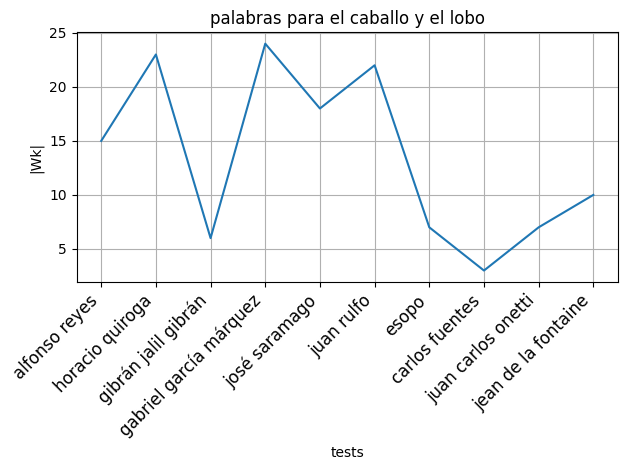

[15, 23, 6, 24, 18, 22, 7, 3, 7, 10]


In [ ]:
i = 0
grafica(autores,palabras[i],f'palabras para {tests[i]}','tests','|Wk|')
print(palabras[i])

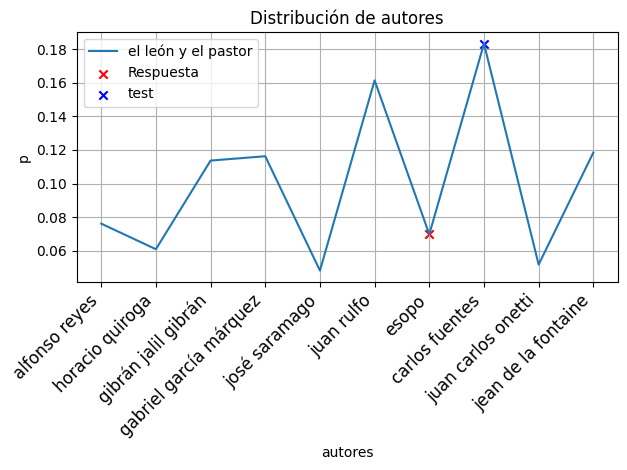

In [ ]:
i = 3
titulo = f'Distribución de autores'
y = y_test[i]
label = tests[i]

grafica_a(autores,y,titulo,label,'autores','p', marker_t[i],marker[i])

In [ ]:
pr = 0
for i in range(len(marker)):
    if marker_t[i] == marker[i]:
        pr += 1
pr / len(tests)

0.4

#### Propuesta 2

$W^o = \{w^o_1, w^o_2,\dots,w^o_{n_o}\}$, donde $w^o_i$ son las palabras observadas en el test que estan presentes en el corpus del entrenamiento.

**Usando aproximación:**
- $P(A|W^o)$, donde 
    - $\forall w^o_i \in W^o, w^o_i = 1$

In [387]:
tests = ['el caballo y el lobo','el impostor', 'la escopeta','el león y el pastor','la marcha del caracol']
autor = ['jean de la fontaine', 'gibrán jalil gibrán', 'juan carlos onetti','esopo','carlos fuentes']
Ns = [10000]
marker_N = []
marker_t_N = []
test_n = 1
autores = list(A.values)
p_test_N = []
vars_s = set([A,T] + [W[w] for w in W.keys()] + [B[b] for b in B.keys()])
descomp = tuple([PA,PT_A] + [PW_AT[w] for w in PW_AT.keys()] + [PB_AT[b] for b in PB_AT.keys()])
Q_ATW = mb.Question(mb.Specification(vars_s,descomp))
for i,test in enumerate(tests):
    print(f"\nTest{i+1}:")
    p = 0
    va = None
    Wo,dWo = test_vocab(test)
    Wo = tuple(Wo+[T])
    vWo = tuple([1 for k in range(len(Wo)-1)]+['minicuento'])
    for Ni in Ns:
        p_test = []
        for a in autores:
            pa = 0
            for j in range(test_n):
                pa_i = Q_ATW.Query(vars=(A,),indep=Wo,vars_values=(a,),indep_values=vWo,aproximation=True,N=Ni)
            
                pa += pa_i
            print(f"P({a}) = {pa}")
            p_test.append(pa/test_n)
            
            if pa/test_n > p:
                p = pa/test_n
                va = a
            
            if a == autor[i]:
                marker_N.append([a,pa])
        marker_t_N.append([va,p])  
        p_test_N.append(p_test)




Test1:
P(carlos fuentes) = 0.0939
P(juan carlos onetti) = 0.1017
P(juan rulfo) = 0.0998
P(alfonso reyes) = 0.1031
P(gibrán jalil gibrán) = 0.0966
P(esopo) = 0.1067
P(josé saramago) = 0.1026
P(jean de la fontaine) = 0.0988
P(gabriel garcía márquez) = 0.105
P(horacio quiroga) = 0.099

Test2:
P(carlos fuentes) = 0.098
P(juan carlos onetti) = 0.0974
P(juan rulfo) = 0.1025
P(alfonso reyes) = 0.0982


KeyboardInterrupt: 

In [234]:
i = 0
y = p_test_N[i]
title = "P(A|X^o_1,...,X^o_(n_o))"
label = Ns[i]
marker_t = marker_t_N[i]
marker = marker_N[i]
grafica_a(autores,y,title,label,'autores','P',marker_t,marker)

IndexError: list index out of range

#### Propuesta 3

Para cada autor ($\forall a_i \in A$):
- $A_i = \{0,1\}$ y  $W^a = \{W^a_1,W^a_2,\dots,W^a_{n_a}\}$
- $P(A_i,T,W^a_1,W^a_2,\dots,W^a_{n_a}) = P(A_i)P(T)\displaystyle \prod_{j=1}^{n_ a} P(W^a_j|A_i,T)$,


In [66]:
autores = set(df_train_T.autor)
tipos = set(df_train_T.tipo)

# Ocurrencias de cada autor y número de ocurrencia de autores
na = Counter(df_train_T.autor)
nA = np.sum(list(na.values()))

# Variables Ai
Ai = {}
for a in autores:
    Ai[a] = mb.Var(a, set([0,1]))

# Variable T 
T = mb.Var('T',tipos)

# Variables Wi
W = {}
for w in nuevo_vocabulario:
    W[w] = mb.Var(w, set([0,1]))

S_Ai = {}

for a in Ai.keys():
    # P(Ai)
    vocab_ai = [w[0] for w in nvocab_a[a]]
    bigram_ai = [b[0] for b in nbigram_a[a]]
    p_ai = na[a] / nA
    tai = {(0,): 1 - p_ai, (1,):p_ai}
    Pai = mb.Distrib(tai, (Ai[a],))
    
    # P(T)
    Pai_T = mb.Distrib(tT_A[(a,)], (T,))
    
    # P(Wj|Ai,T)
    Pai_Wj_AiT = {}
    for w in W:
        tWj_AiT = {}
        
        if w in vocab_ai:
            for t in T.values:
                tWj_AiT[(1,t)] = {(1,):nw_at[(a,t)][w], (0,):0}
                
                nw_notat = 0
                for not_ai in A.values - set([a]):
                    nw_notat += nw_at[(not_ai,t)][w]
                tWj_AiT[(0,t)] = {(1,):nw_notat, (0,):0}
        
        else:
             for t in T.values:
                tWj_AiT[(1,t)] = {(1,):0, (0,):100}
                tWj_AiT[(0,t)] = {(1,):0, (0,):100}
                
        Laplace_gral(tWj_AiT)
        Pai_Wj_AiT[w] = mb.Distrib(tWj_AiT, (W[w],), (Ai[a],T))
         
    # P(Bj|Ai,T)
    Pai_Bj_AiT = {}
    for b in B:
        tBj_AiT = {}
        
        if B in bigram_ai:
            
            for t in T.values:
                tBj_AiT[(1,t)] = {(1,):nb_at[(a,t)][b], (0,):0}
                
                nw_notat = 0
                for not_ai in A.values - set([a]):
                    nw_notat += nb_at[(not_ai,t)][b]
                tBj_AiT[(0,t)] = {(1,):nw_notat, (0,):0}
        
        else:
             for t in T.values:
                tBj_AiT[(1,t)] = {(1,):0, (0,):100}
                tBj_AiT[(0,t)] = {(1,):0, (0,):100}
                
        Laplace_gral(tBj_AiT)
        Pai_Bj_AiT[b] = mb.Distrib(tBj_AiT, (B[b],), (Ai[a],T))

    vars = set([Ai[a],T] + [W[w] for w in W.keys()] + [B[b] for b in B.keys()])
    descomp = tuple([Pai, Pai_T] + [Pai_Wj_AiT[w] for w in W.keys()] \
                    + [Pai_Bj_AiT[b] for b in B.keys()])
    S_Ai[a] = mb.Specification(vars, descomp)

In [67]:
def test_vocab(titulo:str) -> tuple:
    dcont = df_test_T.loc[df_test_T['titulo'] == titulo, 'tokens_c'].iloc[0]
    wt = []
    for w in dcont:
        wt.append(W[w])
    
    bcont = df_test_T.loc[df_test_T['titulo'] == titulo, 'bigramas_c'].iloc[0]
    bt = []
    for b in bcont:
        bt.append(B[b])
            
    return wt, bt

In [68]:
for a in S_Ai:
    print(S_Ai[a].H())

63.55229228856574
51.029089880585744
69.02555476556877
41.255829163375694
41.41155731984287
41.25216906890415
46.0346586930561
41.25216906890415
41.258383527530654
46.350874417637655


In [69]:
Q_Ai = {}
for a in S_Ai:
    Q_Ai[a] = mb.Question(S_Ai[a])

In [70]:
tests = ['el caballo y el lobo','el impostor', 'la escopeta','el león y el pastor','la marcha del caracol']
autor = ['jean de la fontaine', 'gibrán jalil gibrán', 'juan carlos onetti','esopo','carlos fuentes']
marker = []
marker_t = []
test_n = []
nvocab_a_w = {}
nbigram_a_b = {}
for a in A.values:
    nvocab_a_w[a] = set([w[0] for w in nvocab_a[a]])
    nbigram_a_b[a] = set([b[0] for b in nbigram_a[a]])


for i,test in enumerate(tests):
    test_i = []
    print(f"\nCargando test {i+1}")
    Wo, Bo = test_vocab(test)
    
    vocab_t = set()
    for v in Wo:
        vocab_t.add(v.name)
    print(vocab_t)
    
    bigram_t = set()
    for v in Bo:
        bigram_t.add(v.name)
    print(len(bigram_t))
    
    Wo = tuple(Wo+Bo+[T])
    vWo = tuple([1 for i in range(len(Wo)-1)]+['minicuento'])
    p = 0
    a_t = None
    for a in Q_Ai.keys():
        print(f"\t{vocab_t.intersection(nvocab_a_w[a])}")
        print(f"\t{len(bigram_t.intersection(nbigram_a_b[a]))}")
        Ai = (S_Ai[a].getVar(a),)
        pa = Q_Ai[a].Query(vars=Ai,indep=Wo,vars_values=(1,),indep_values=vWo, aproximation=True,N=20000,process_n=8)
        print(f"\tP({a}) = {pa}")
        
        if pa > p:
            p = pa
            a_t = a
            
        if a == autor[i]:
            marker.append([a,pa]) 
        test_i.append(pa)
    marker_t.append([a_t,p])    
    test_n.append(test_i)


Cargando test 1
{'si'}
55
	{'si'}
	39
	P(juan rulfo) = 0.49925625
	set()
	37
	P(horacio quiroga) = 0.4995375
	{'si'}
	52
	P(carlos fuentes) = 0.50215625
	set()
	9
	P(esopo) = 0.49905
	set()
	31
	P(gabriel garcía márquez) = 0.50109375
	set()
	21
	P(jean de la fontaine) = 0.499825
	set()
	19
	P(josé saramago) = 0.4999875
	set()
	15
	P(alfonso reyes) = 0.4984
	set()
	17
	P(juan carlos onetti) = 0.49995625
	set()
	21
	P(gibrán jalil gibrán) = 0.50024375

Cargando test 2
{'si'}
53
	{'si'}
	39
	P(juan rulfo) = 0.4998375
	set()
	35
	P(horacio quiroga) = 0.498925
	{'si'}
	50
	P(carlos fuentes) = 0.500525
	set()
	9
	P(esopo) = 0.49845
	set()
	32
	P(gabriel garcía márquez) = 0.50004375
	set()
	20
	P(jean de la fontaine) = 0.5015875
	set()
	18
	P(josé saramago) = 0.50074375
	set()
	14
	P(alfonso reyes) = 0.50063125
	set()
	17
	P(juan carlos onetti) = 0.500475
	set()
	20
	P(gibrán jalil gibrán) = 0.50033125

Cargando test 3
set()
44
	set()
	34
	P(juan rulfo) = 0.5015875
	set()
	33
	P(horacio quir

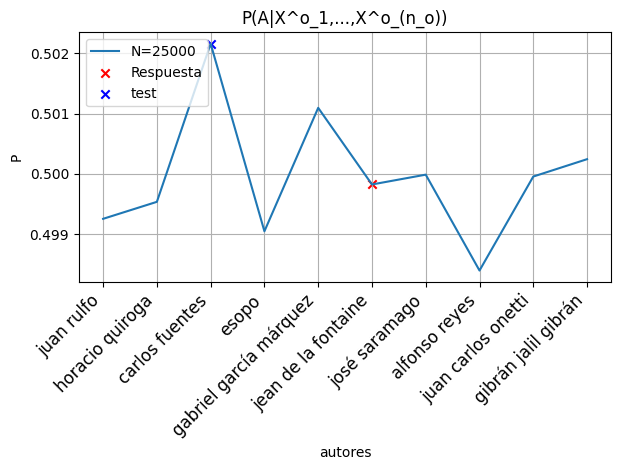

In [71]:
i = 0
y = test_n[i]
title = "P(A|X^o_1,...,X^o_(n_o))"
label = "N=25000"
mt = marker_t[i]
m = marker[i]
grafica_a(list(Q_Ai.keys()),y,title,label,'autores','P',mt,m)